<a href="https://colab.research.google.com/github/gyanendar/ms_project/blob/main/GoogLeNet_BaseLine2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Author: Gyanendar Manohar

Description: Implementation of GoogLeNet based CNN

A. Cerentinia, D. Welfera, C. J. P. Haygertb, and G. N. Dottob, “Automatic iden-
tification of glaucoma using deep learning methods,” 2018.

In [ ]:
import os
import random
from tabnanny import verbose
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import argparse
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow.keras.backend as K
from tensorflow.keras import initializers, layers
from sklearn.metrics import confusion_matrix,accuracy_score
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
RIM_ONE_DL_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/RIM-ONE_DL_images/partitioned_randomly'
RIM_ONE_R2_DIR= '/content/gdrive/My Drive/MSC_Project/Dataset/RIMONE-db-r2'
ACRIMA_DIR = '/content/gdrive/My Drive/MSC_Project/Dataset/ACRIMA'
DRISHTI_GS1 = '/content/gdrive/My Drive/MSC_Project/Dataset/Drishti-GS1'
SAVE_FILE_PERFORMANCE_TRAINED = r'/content/gdrive/My Drive/MSC_Project/Model/CNN/generated_data/baseline_2_22_04.csv'

In [ ]:
def initialise_df_perfromance_matrix():
  g_performance_df =  pd.DataFrame([], columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
initialise_df_perfromance_matrix()

In [ ]:
def save_performance_data(new_data):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  data_list = g_performance_df.values.tolist()
  data_exist = False
  for index in range(len(data_list)):
    if(data_list[index][0]==new_data[0]):
      data_list[index] = new_data
      data_exist = True
  if(data_exist==False):
    data_list.append(new_data)
  g_performance_df = pd.DataFrame(data_list, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','kappa'])
  g_performance_df.to_csv(SAVE_FILE_PERFORMANCE_TRAINED, encoding='utf-8', index=False)

In [ ]:
def plot_performance(dataset='RIM-ONE_v2'):
  g_performance_df = pd.read_csv(SAVE_FILE_PERFORMANCE_TRAINED)
  filtered_df = g_performance_df[g_performance_df["Model"].str.contains(dataset)]
  display(filtered_df)
  plt.figure()
  plot = sns.barplot(y='Model', x='Accuracy', data=filtered_df)
  plt.show()

  print(filtered_df.to_latex(index=False))

In [ ]:

BATCH_SIZE = 32
CLASS_COUNT = 2
NUM_EPOCHS_A = 30
NUM_EPOCHS_B = 25
g_performance = {}

In [ ]:
# Resize image to 256*256
# Convert to numpy array
def process_image(data_set_dir, label_dict, width, height):
    
    x = [] # will store images as arrays
    y = [] # store labels
    # list folders in directory
    directories = os.listdir(data_set_dir)
     
    # for each folder (train and validation) 
    for label in directories:
        
        # add class label to label dictionary
        if label not in label_dict:
            label_dict[label] = len(label_dict)
        
        # create full path for image directory 
        source_images = os.path.join(data_set_dir, label)
        images = os.listdir(source_images)
        # for each image in directory, 
        for image in images:
            #folder have .txt files which needs to be ignored
            if '.txt'not in image:
                # read the image from file, resize and add to a list
                full_size_image = cv2.imread(os.path.join(source_images, image))
                
                #append the image to x
                x.append(cv2.resize(full_size_image, (width,height), 
                                                            interpolation=cv2.INTER_CUBIC))
                # add the class label to y
                y.append(label)

   
    data = np.array(x, dtype="float") / 255.0                
    label = np.array(y)
    
    return data,label

In [ ]:
def set_seed():
  tf.random.set_seed(100)
  np.random.seed(100)
  random.seed(100)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

def get_early_stoping_cb_on_min_val_loss(patience_num = 10):
  return EarlyStopping(monitor='val_loss', mode='min', verbose=0, \
                       patience=patience_num)

def get_model_checkpoint_cb_on_max_val_acc(file_name):
  return ModelCheckpoint(file_name, monitor="val_loss", 	mode="min", \
                         save_best_only=True, verbose=1)	

def learning_rate_schedular_fun(epoch, lr):
  if epoch <10:
    return lr 
  else:
    #return lr*tf.math.exp(-.1)
    return lr*0.1
  
def get_model_learning_rate_cb():
  return tf.keras.callbacks.LearningRateScheduler(learning_rate_schedular_fun,\
                                                  verbose=0)


def get_basic_callback():
  return [get_early_stoping_cb_on_min_val_loss()]

def get_basic_and_lrs_callback():
  return [get_early_stoping_cb_on_min_val_loss(),get_model_learning_rate_cb()]

def get_all_callback(file_name):
  return [get_early_stoping_cb_on_min_val_loss(),\
          #get_model_learning_rate_cb(),\
          get_model_checkpoint_cb_on_max_val_acc(file_name)]

In [ ]:
# Returns Pretrained Network with top layer removed
# And Trainable set to false

def get_high_level_model(trained_model_name):
  #set_seed()
  model = None
  if trained_model_name == "vgg16":
      model = tf.keras.applications.VGG16(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
      
  elif trained_model_name == "vgg19":
      model =  tf.keras.applications.VGG19(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
      
  elif trained_model_name == "resnet50":
     model = tf.keras.applications.ResNet50(weights='imagenet', \
                              include_top = False, input_shape = (224,224,3))
     
  elif trained_model_name == "xception":
     model = tf.keras.applications.Xception(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))
     
  elif trained_model_name == "DenseNet121":
     model = tf.keras.applications.DenseNet121(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "MobileNet":
     model = tf.keras.applications.MobileNet(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "MobileNetV2":
     model = tf.keras.applications.MobileNetV2(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))
  elif trained_model_name == "InceptionResNetV2":
     model = tf.keras.applications.InceptionResNetV2(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))
  elif trained_model_name == "InceptionV3":
     model = tf.keras.applications.InceptionV3(weights='imagenet', \
                            include_top = False, input_shape = (299,299,3))  
  elif trained_model_name == "NASNetMobile":
     model = tf.keras.applications.NASNetMobile(weights='imagenet', \
                            include_top = False, input_shape = (224,224,3))  

  elif trained_model_name == "NasNetLarge":
     model = tf.keras.applications.NASNetLarge(weights='imagenet', \
                            include_top = False, input_shape = (331,331,3))       
  
  if model != None:
    for layer in model.layers:
       layer.trainable = False

  return model

In [ ]:
def get_resizing_layer(model_name):
   if model_name == 'NasNetLarge':
      return tf.keras.Sequential([tf.keras.layers.Resizing(331, 331)])
   elif model_name == 'InceptionV3' or model_name == 'xception' or model_name == 'InceptionResNetV2':
      return tf.keras.Sequential([tf.keras.layers.Resizing(299, 299)])
   else:
      return tf.keras.Sequential([tf.keras.layers.Resizing(224, 224)])

In [ ]:
def plot_model_performance(history,model_name,part):
  plt.style.use("ggplot")
  plt.figure(figsize=(7,6))
  epoch_ran = len(history.history["loss"])
  plt.plot(np.arange(0, epoch_ran), \
           history.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epoch_ran), \
           history.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()
  plt.show()

  #Print best score 
 
  print("\nModel Performance Summary:\n")
  
  

  epoch_index = history.history["val_accuracy"].index(max(history.history["val_accuracy"]))
    
  best_val_accuracy = history.history["val_accuracy"][epoch_index]

  print(f"Best Validation accuracy:{best_val_accuracy} at EPOCH:{epoch_index+1}")

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']
  initial_epochs = len(history.history["loss"])
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(acc, label='Training Accuracy')
  plt.plot(val_acc, label='Validation Accuracy')
  plt.ylim([0.8, 1])
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.ylim([0, 1.0])
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

In [ ]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 50
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img

In [ ]:
import gc

class HIGH_LEVEL_MODEL:
  def __init__(self, trained_model_name):

    set_seed()
    
    #Start constructing the model with pretrained network 
    self.model = tf.keras.models.Sequential(name = trained_model_name)
    self.model.add(get_resizing_layer(trained_model_name))
    # Get Pretrained model with top layer removed and trainable parameter frozen
    self.high_level_model_obj = get_high_level_model(trained_model_name)
    self.model.add(self.high_level_model_obj)
    
    # Flatten the output and add FC & Softmax layer
    self.model.add(tf.keras.layers.Flatten())
    #self.model.add(tf.keras.layers.GlobalAveragePooling2D())
    
    #self.model.add(tf.keras.layers.Dense(512, activation='relu'))  
    self.model.add(tf.keras.layers.Dense(CLASS_COUNT, activation='softmax'))                             
    
    #Model is constructed Now
    #print(self.model.summary())    
    
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    #display(plot_model(self.model, show_shapes=True, expand_nested=True))
    #self.kfold = KFold(n_splits=self.fold_count, shuffle=True)
    # Setting Model JSON file and weight filte name 
    self.model_file_name = self.model.name+".json"
    #for index in range(0,fold):
    self.model_wt_file_name_a = f"{self.model.name}_a.hdf5"
    self.model_wt_file_name_b = f"{self.model.name}_b.hdf5"
    self.model_wt_file_name = f"{self.model.name}_wt.hdf5"
    
    # To identify the variantion in parameter 
    #self.model_varient = varient

  def train_phase(self,train_x,train_y,test_x,test_y,model_name,data_aug = False,lr=0.0001):
    
    train_data_generator = ImageDataGenerator()
    if data_aug == True:
      train_data_generator = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=10, fill_mode='nearest',zoom_range=0.2 )
    
    train_generator = train_data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE)
   
    val_data_generator = ImageDataGenerator()
    val_generator = val_data_generator.flow(test_x, test_y, batch_size=BATCH_SIZE)

    self.model.compile(loss='categorical_crossentropy', \
          optimizer=tf.keras.optimizers.Adam(learning_rate=lr),metrics=['accuracy'])
    
    model_json = self.model.to_json()
    with open(self.model_file_name, "w") as json_file:
      json_file.write(model_json)

    history = self.model.fit(train_generator, epochs=NUM_EPOCHS_A, \
                   batch_size=BATCH_SIZE, validation_data=val_generator, \
                   callbacks = get_all_callback(self.model_wt_file_name_a),verbose=1)        
    best_val_accuracy = max(history.history["val_accuracy"])
    #self.fold_accuracy_a.append(best_val_accuracy)
      
    plot_model_performance(history,self.model.name,"phase_a")

    self.model.load_weights(self.model_wt_file_name_a)
    #self.high_level_model_obj.trainable = True

    #optimizer_obj = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
    #self.model.compile(loss='categorical_crossentropy',
    #            optimizer=optimizer_obj,
    #            metrics=['accuracy'])
    
    #history = self.model.fit(train_generator, epochs=NUM_EPOCHS_B, \
    #               batch_size=BATCH_SIZE, validation_data=val_generator, \
    #               callbacks = get_all_callback(self.model_wt_file_name_b))

    #plot_model_performance(history,self.model.name,"phase_b")
    gc.collect()

    
    #self.model.load_weights(self.model_wt_file_name_a)
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    actual_val = test_y.argmax(axis=-1)

    tn, fp, fn, tp = confusion_matrix(actual_val, self.y_classes).ravel()
    final_accuracy = accuracy_score(actual_val, self.y_classes)
    final_sensitivity=tp/(tp+fn)
    print("Accuracy:",final_accuracy)
    print("Sensitivity:",final_sensitivity)
    specificity = tn/(tn+fp)
    kappa = cohen_kappa_score(actual_val, self.y_classes)
    #self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    #self.roc_auc = auc(self.fpr, self.tpr)
    #plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)     
    
    fpr, tpr, thresholds = metrics.roc_curve(actual_val, self.y_classes)
    auc = metrics.auc(fpr, tpr)
    print(f"AUC:{auc}")
    precision = precision_score(actual_val, self.y_classes)
    recall = recall_score(actual_val, self.y_classes)
    f1 = f1_score(actual_val, self.y_classes)

   
    model_performance = [(model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa)]
    df = pd.DataFrame(model_performance, columns = ['Model', 'Accuracy','Precision','Recall','F1','AUC','Sensitivity','Specificity','Kappa'])
    display(df)
    save_performance_data([model_name,final_accuracy,precision,recall,f1,auc,final_sensitivity,specificity,kappa])
    
 
  def get_scores(self,test_x,test_y):

    #index= self.fold_accuracy_b.index(max(self.fold_accuracy_b))
    #self.model.load_weights(self.model_wt_file_name_b[index])
    self.model.load_weights(self.model_wt_file_name_a)
    optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.0001)
    self.model.compile(loss='categorical_crossentropy',
                optimizer=optimizer_obj,
                metrics=['accuracy'])
    
    predicted_val = self.model.predict(test_x,verbose = 1)
    self.y_classes = predicted_val.argmax(axis=-1)
    actual_val = test_y.argmax(axis=-1)

    tn, fp, fn, tp = confusion_matrix(actual_val, self.y_classes).ravel()
    print("Accuracy:",accuracy_score(actual_val, self.y_classes))
    print("Sensitivity:",tp/(tp+fn))
    
    #self.fpr, self.tpr, _ = roc_curve(test_y, self.y_classes)
    #self.roc_auc = auc(self.fpr, self.tpr)
    #plot_ROC_AUC(self.fpr, self.tpr, self.roc_auc)  

In [ ]:
def get_rim_one_db_r2(width,height,test_train_ratio = 0.2,histogram_eq = False):
  print(f"Height:{height} Width:{width} test_train_ratio:{test_train_ratio}")
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_R2_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
def get_rim_one_dl(width,height,histogram_eq = False):
  class_labels = {}
  training_images,training_labels = process_image(RIM_ONE_DL_DIR+"/training_set",
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, height, 3).astype('float32')

  test_images,test_labels = process_image(RIM_ONE_DL_DIR+"/test_set",
                                          class_labels,
                                          width,height)
  
  test_label = (pd.Series(test_labels).map(class_labels)).values
  test_label = to_categorical(test_label.astype('float32'))
  test_images = test_images.reshape(-1, width, height, 3).astype('float32')

  return (training_images,training_label),(test_images,test_label)

In [ ]:
def get_acrima_dataset(width,height,test_train_ratio = 0.2):
  print(f"Height:{height} Width:{width}")
  class_labels = {}
  training_images,training_labels = process_image(ACRIMA_DIR,
                                                  class_labels,
                                                  width,height)
  
  training_label = (pd.Series(training_labels).map(class_labels)).values
  training_label = to_categorical(training_label.astype('float32'))
  training_images = training_images.reshape(-1, width, width, 3).astype('float32')

  X_train, X_test, y_train, y_test = train_test_split(training_images, 
                                                      training_label, 
                                                      test_size=test_train_ratio, 
                                                      random_state=100)

  return (X_train,y_train),(X_test,y_test)

In [ ]:
(trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 256,height = 256,test_train_ratio = 0.2)

Height:256 Width:256


Height:299 Width:299 test_train_ratio:0.1
A_False_Split_0.1_lr_0.0001
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.1340 - accuracy: 0.6064
Epoch 1: val_loss improved from inf to 0.67874, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 9s 272ms/step - loss: 1.1340 - accuracy: 0.6064 - val_loss: 0.6787 - val_accuracy: 0.7174
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8191
Epoch 2: val_loss did not improve from 0.67874
13/13 [==============================] - 1s 92ms/step - loss: 0.4123 - accuracy: 0.8191 - val_loss: 0.7337 - val_accuracy: 0.7174
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9095
Epoch 3: val_loss improved from 0.67874 to 0.56313, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 2s 150ms/step - loss: 0.2011 - accuracy: 0.9095 - val_loss: 0.5631 - val_accuracy: 0.7826
Epoch 4/30
13/13 [=====================

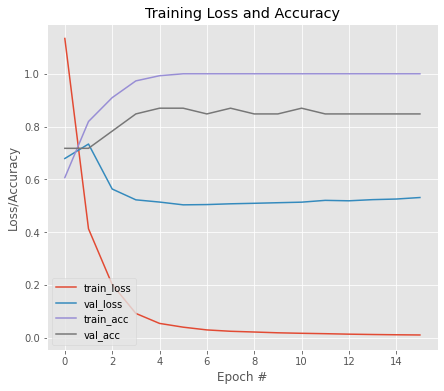


Model Performance Summary:

Best Validation accuracy:0.8695651888847351 at EPOCH:5


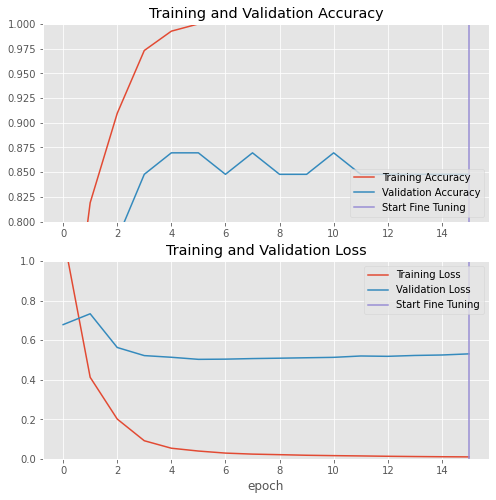

2/2 [==============================] - 2s 66ms/step
Accuracy: 0.8695652173913043
Sensitivity: 0.8636363636363636
AUC:0.8693181818181819


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.1_0.0001_InceptionV3  0.869565   0.863636  0.863636   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.863636  0.869318     0.863636        0.875  0.738636

A_True_Split_0.1_lr_0.0001
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.1916 - accuracy: 0.5917
Epoch 1: val_loss improved from inf to 0.74006, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 15s 756ms/step - loss: 1.1916 - accuracy: 0.5917 - val_loss: 0.7401 - val_accuracy: 0.6522
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.6225 - accuracy: 0.7482
Epoch 2: val_loss did not improve from 0.74006
13/13 [==============================] - 8s 580ms/step - loss: 0.6225 - accuracy: 0.7482 - val_loss: 0.7465 - val_accuracy: 0.8043
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.4650 - accuracy: 0.7897
Epoch 3: val_loss improved from 0.74006 to 0.71686, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 8s 640ms/step - loss: 0.4650 - accuracy: 0.7897 - val_loss: 0.7169 - val_accuracy: 0.7391
Epoch 4/30
13/13 [==============================] - ETA: 0s - loss: 0.3810 - acc

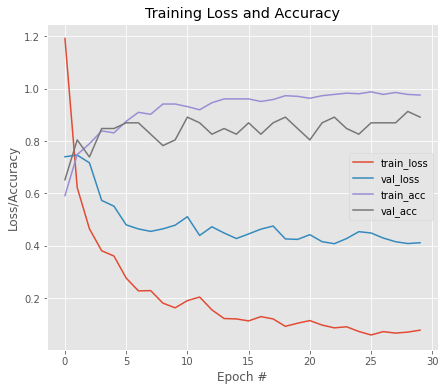


Model Performance Summary:

Best Validation accuracy:0.9130434989929199 at EPOCH:29


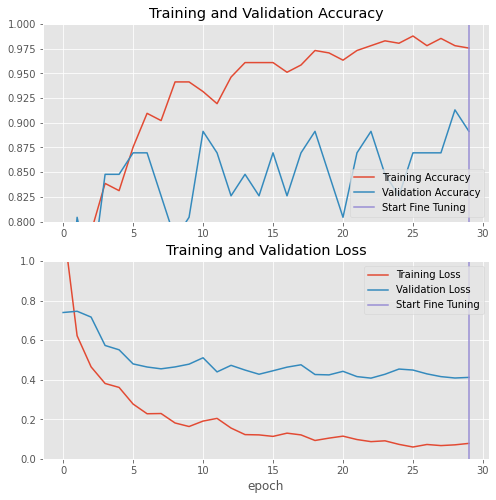

2/2 [==============================] - 2s 71ms/step
Accuracy: 0.8913043478260869
Sensitivity: 0.9090909090909091
AUC:0.8920454545454545


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_True_0.1_0.0001_InceptionV3  0.891304   0.869565  0.909091   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.888889  0.892045     0.909091        0.875  0.782609

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.6016
Epoch 1: val_loss improved from inf to 0.61795, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 10s 311ms/step - loss: 0.9623 - accuracy: 0.6016 - val_loss: 0.6179 - val_accuracy: 0.7253
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8654
Epoch 2: val_loss improved from 0.61795 to 0.46778, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 2s 165ms/step - loss: 0.3237 - accuracy: 0.8654 - val_loss: 0.4678 - val_accuracy: 0.8681
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9313
Epoch 3: val_loss improved from 0.46778 to 0.33087, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 2s 159ms/step - loss: 0.1623 - accuracy: 0.9313 - val_loss: 0.3309 - val_accuracy: 0.90

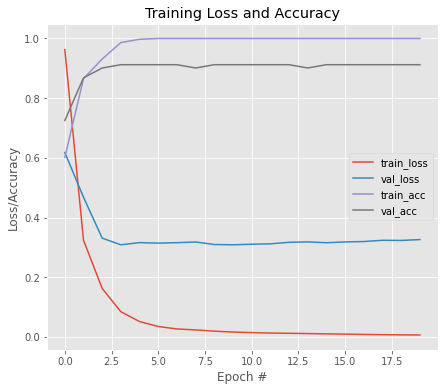


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:4


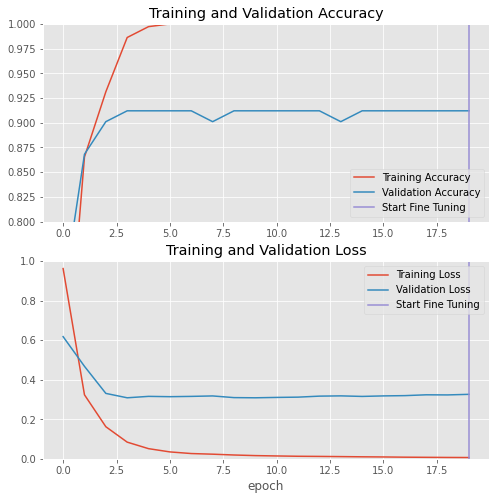

3/3 [==============================] - 2s 75ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.8780487804878049
AUC:0.9090243902439024


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077  0.878049   

    F1       AUC  Sensitivity  Specificity     Kappa  
0  0.9  0.909024     0.878049         0.94  0.821656

A_True_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.9983 - accuracy: 0.5632
Epoch 1: val_loss improved from inf to 0.73213, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 15s 793ms/step - loss: 0.9983 - accuracy: 0.5632 - val_loss: 0.7321 - val_accuracy: 0.6923
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4951 - accuracy: 0.7692
Epoch 2: val_loss improved from 0.73213 to 0.66539, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 8s 638ms/step - loss: 0.4951 - accuracy: 0.7692 - val_loss: 0.6654 - val_accuracy: 0.7473
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.4346 - accuracy: 0.8132
Epoch 3: val_loss improved from 0.66539 to 0.55625, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 8s 650ms/step - loss: 0.4346 - accuracy: 0.8132 - val_loss: 0.5563 - val_accuracy: 0.7692
Epoch 4/30
12/12 [======================

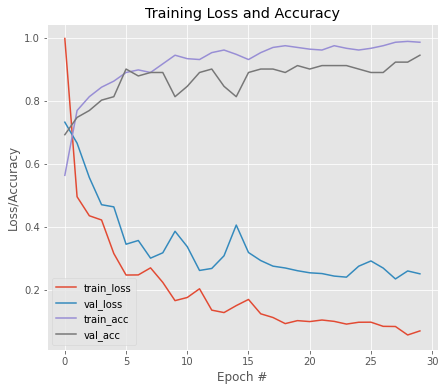


Model Performance Summary:

Best Validation accuracy:0.9450549483299255 at EPOCH:30


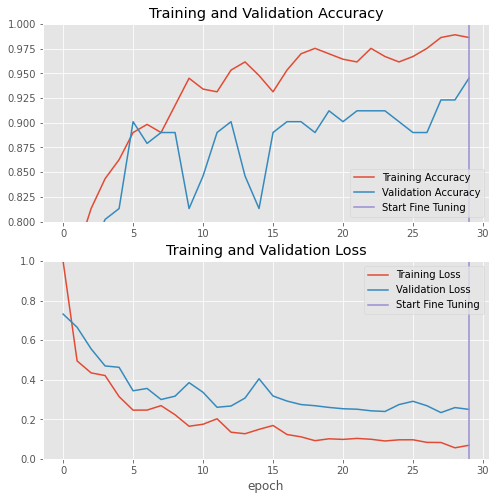

3/3 [==============================] - 2s 71ms/step
Accuracy: 0.9230769230769231
Sensitivity: 0.9024390243902439
AUC:0.9212195121951219


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_True_0.2_0.0001_InceptionV3  0.923077      0.925  0.902439   

        F1      AUC  Sensitivity  Specificity     Kappa  
0  0.91358  0.92122     0.902439         0.94  0.844292

Height:299 Width:299 test_train_ratio:0.3
A_False_Split_0.3_lr_0.0001
Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 1.0924 - accuracy: 0.6101
Epoch 1: val_loss improved from inf to 0.63872, saving model to InceptionV3_a.hdf5
10/10 [==============================] - 10s 380ms/step - loss: 1.0924 - accuracy: 0.6101 - val_loss: 0.6387 - val_accuracy: 0.7007
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.4421 - accuracy: 0.8113
Epoch 2: val_loss did not improve from 0.63872
10/10 [==============================] - 1s 122ms/step - loss: 0.4421 - accuracy: 0.8113 - val_loss: 0.7414 - val_accuracy: 0.6934
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.2485 - accuracy: 0.8931
Epoch 3: val_loss improved from 0.63872 to 0.37795, saving model to InceptionV3_a.hdf5
10/10 [==============================] - 2s 198ms/step - loss: 0.2485 - accuracy: 0.8931 - val_loss: 0.3780 - val_accuracy: 0.8467
Epoch 4/30
10/10 [===================

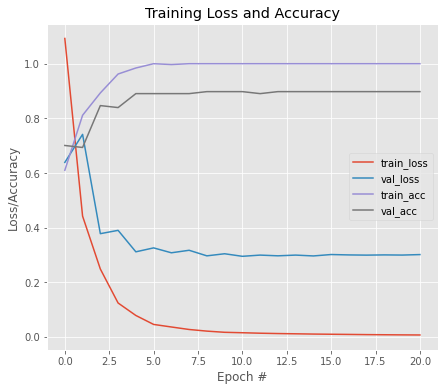


Model Performance Summary:

Best Validation accuracy:0.8978102207183838 at EPOCH:9


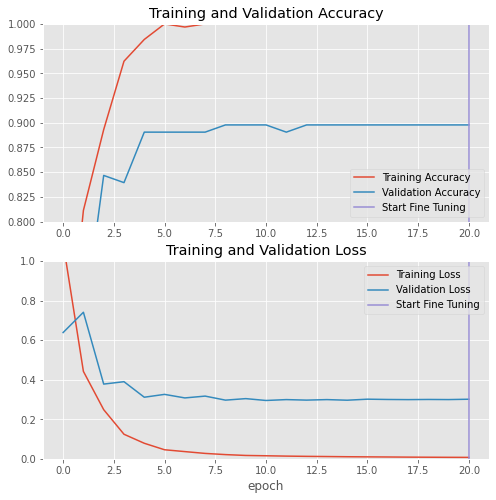

5/5 [==============================] - 2s 72ms/step
Accuracy: 0.8978102189781022
Sensitivity: 0.8448275862068966
AUC:0.8907682234831951


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.3_0.0001_InceptionV3   0.89781   0.907407  0.844828   

      F1       AUC  Sensitivity  Specificity     Kappa  
0  0.875  0.890768     0.844828     0.936709  0.788767

A_True_Split_0.3_lr_0.0001
Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.7153 - accuracy: 0.6792
Epoch 1: val_loss improved from inf to 0.57207, saving model to InceptionV3_a.hdf5
10/10 [==============================] - 15s 890ms/step - loss: 0.7153 - accuracy: 0.6792 - val_loss: 0.5721 - val_accuracy: 0.7591
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.4564 - accuracy: 0.7956
Epoch 2: val_loss improved from 0.57207 to 0.39647, saving model to InceptionV3_a.hdf5
10/10 [==============================] - 7s 709ms/step - loss: 0.4564 - accuracy: 0.7956 - val_loss: 0.3965 - val_accuracy: 0.8102
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.4154 - accuracy: 0.8270
Epoch 3: val_loss improved from 0.39647 to 0.36246, saving model to InceptionV3_a.hdf5
10/10 [==============================] - 7s 707ms/step - loss: 0.4154 - accuracy: 0.8270 - val_loss: 0.3625 - val_accuracy: 0.8394
Epoch 4/30
10/10 [======================

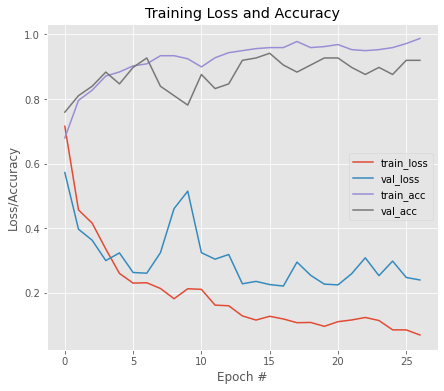


Model Performance Summary:

Best Validation accuracy:0.9416058659553528 at EPOCH:16


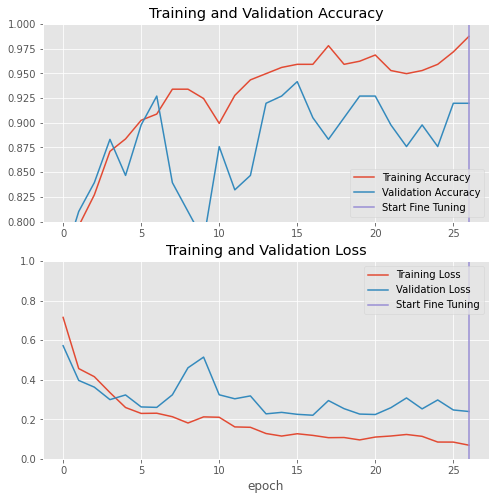

5/5 [==============================] - 2s 71ms/step
Accuracy: 0.9051094890510949
Sensitivity: 0.8448275862068966
AUC:0.8970973374072456


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_True_0.3_0.0001_InceptionV3  0.905109   0.924528  0.844828   

         F1       AUC  Sensitivity  Specificity   Kappa  
0  0.882883  0.897097     0.844828     0.949367  0.8034

Height:299 Width:299 test_train_ratio:0.4
A_False_Split_0.4_lr_0.0001
Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 0.9581 - accuracy: 0.6337
Epoch 1: val_loss improved from inf to 0.58868, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 9s 422ms/step - loss: 0.9581 - accuracy: 0.6337 - val_loss: 0.5887 - val_accuracy: 0.7253
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.4238 - accuracy: 0.8168
Epoch 2: val_loss improved from 0.58868 to 0.57843, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 2s 222ms/step - loss: 0.4238 - accuracy: 0.8168 - val_loss: 0.5784 - val_accuracy: 0.7527
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.2866 - accuracy: 0.8755
Epoch 3: val_loss improved from 0.57843 to 0.31999, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 2s 239ms/step - loss: 0.2866 - accuracy: 0.8755 - val_loss: 0.3200 - val_accuracy: 0.8736
Epoch 4/30

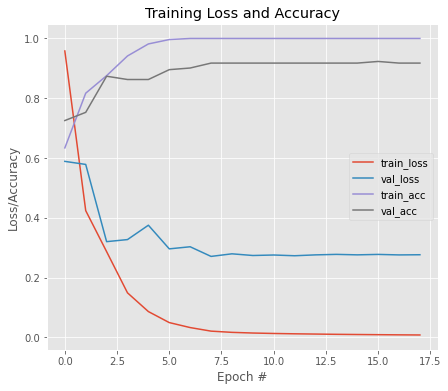


Model Performance Summary:

Best Validation accuracy:0.9230769276618958 at EPOCH:16


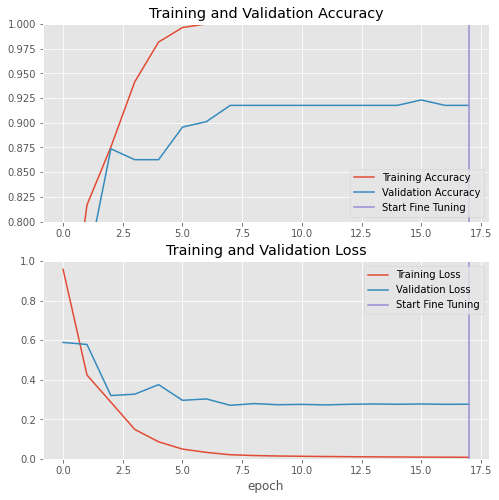

6/6 [==============================] - 2s 71ms/step
Accuracy: 0.9175824175824175
Sensitivity: 0.8734177215189873
AUC:0.9124370160992995


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.4_0.0001_InceptionV3  0.917582   0.932432  0.873418   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.901961  0.912437     0.873418     0.951456  0.831002

A_True_Split_0.4_lr_0.0001
Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.1270 - accuracy: 0.5092
Epoch 1: val_loss improved from inf to 1.32893, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 14s 901ms/step - loss: 1.1270 - accuracy: 0.5092 - val_loss: 1.3289 - val_accuracy: 0.6044
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 0.8265 - accuracy: 0.6484
Epoch 2: val_loss improved from 1.32893 to 0.52226, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 6s 711ms/step - loss: 0.8265 - accuracy: 0.6484 - val_loss: 0.5223 - val_accuracy: 0.7527
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 0.5327 - accuracy: 0.7985
Epoch 3: val_loss improved from 0.52226 to 0.40828, saving model to InceptionV3_a.hdf5
9/9 [==============================] - 6s 710ms/step - loss: 0.5327 - accuracy: 0.7985 - val_loss: 0.4083 - val_accuracy: 0.8352
Epoch 4/30
9/9 [==============================] - ET

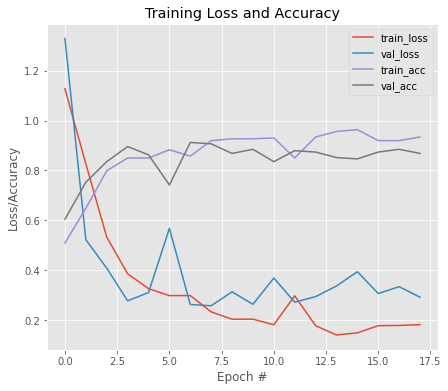


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:7


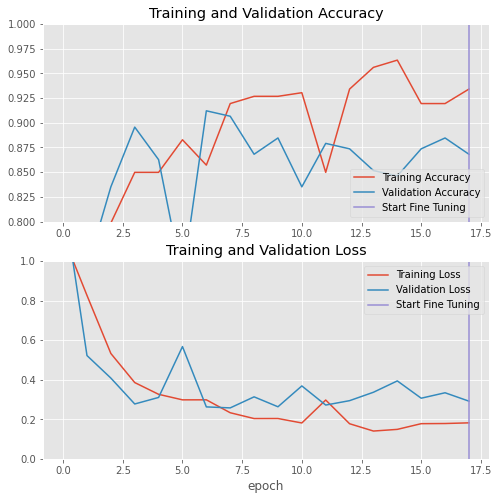

6/6 [==============================] - 2s 72ms/step
Accuracy: 0.9065934065934066
Sensitivity: 0.8354430379746836
AUC:0.8983040432591864


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_True_0.4_0.0001_InceptionV3  0.906593   0.942857  0.835443   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.885906  0.898304     0.835443     0.961165  0.807323

In [ ]:
split_ratio = [0.1,0.2,0.3,0.4]
data_aug = [False,True]
learning_rate = [0.0001]
set_seed()
for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = ratio)
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{ratio}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL("InceptionV3")
      name = f"RIM-ONE_v2_A_{aug}_{ratio}_{lr}_InceptionV3"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)



Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.1_0.0001_InceptionV3  0.869565   0.863636  0.863636   
1  RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077  0.878049   
2  RIM-ONE_v2_A_False_0.3_0.0001_InceptionV3  0.897810   0.907407  0.844828   
3  RIM-ONE_v2_A_False_0.4_0.0001_InceptionV3  0.917582   0.932432  0.873418   
4   RIM-ONE_v2_A_True_0.1_0.0001_InceptionV3  0.891304   0.869565  0.909091   
5   RIM-ONE_v2_A_True_0.2_0.0001_InceptionV3  0.923077   0.925000  0.902439   
6   RIM-ONE_v2_A_True_0.3_0.0001_InceptionV3  0.905109   0.924528  0.844828   
7   RIM-ONE_v2_A_True_0.4_0.0001_InceptionV3  0.906593   0.942857  0.835443   

         F1       AUC  Sensitivity  Specificity     kappa  
0  0.863636  0.869318     0.863636     0.875000  0.738636  
1  0.900000  0.909024     0.878049     0.940000  0.821656  
2  0.875000  0.890768     0.844828     0.936709  0.788767  
3  0.901961  0.912437     0.873418     0.951456  0.831002  
4  0.888889  0.892045     0.909091     0.875000  0.782609  
5  0.913580  0.921220     0.902439     0.940000  0.844292  
6  0.882883  0.897097     0.844828     0.949367  0.803400  
7  0.885906  0.898304     0.835443     0.961165  0.807323

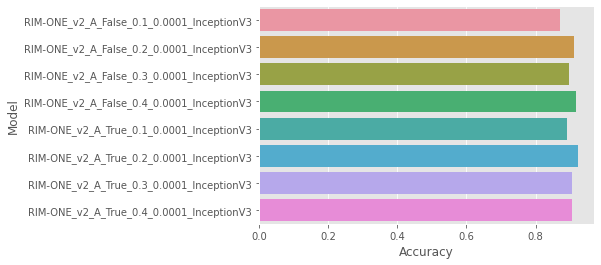

\begin{tabular}{lrrrrrrrr}
\toprule
                                    Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
RIM-ONE\_v2\_A\_False\_0.1\_0.0001\_InceptionV3 &  0.869565 &   0.863636 & 0.863636 & 0.863636 & 0.869318 &     0.863636 &     0.875000 & 0.738636 \\
RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.912088 &   0.923077 & 0.878049 & 0.900000 & 0.909024 &     0.878049 &     0.940000 & 0.821656 \\
RIM-ONE\_v2\_A\_False\_0.3\_0.0001\_InceptionV3 &  0.897810 &   0.907407 & 0.844828 & 0.875000 & 0.890768 &     0.844828 &     0.936709 & 0.788767 \\
RIM-ONE\_v2\_A\_False\_0.4\_0.0001\_InceptionV3 &  0.917582 &   0.932432 & 0.873418 & 0.901961 & 0.912437 &     0.873418 &     0.951456 & 0.831002 \\
 RIM-ONE\_v2\_A\_True\_0.1\_0.0001\_InceptionV3 &  0.891304 &   0.869565 & 0.909091 & 0.888889 & 0.892045 &     0.909091 &     0.875000 & 0.782609 \\
 RIM-ONE\_v2\_A\_True\_0.2\_0.0001\_InceptionV3 &  0.923077 &

In [ ]:
plot_performance()

RIMONE DL DATASET

A_True_Split_0.3_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6870 - accuracy: 0.6814
Epoch 1: val_accuracy improved from -inf to 0.72603, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 12s 727ms/step - loss: 0.6870 - accuracy: 0.6814 - val_loss: 0.5861 - val_accuracy: 0.7260
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.4050 - accuracy: 0.8171
Epoch 2: val_accuracy improved from 0.72603 to 0.78767, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 7s 625ms/step - loss: 0.4050 - accuracy: 0.8171 - val_loss: 0.4528 - val_accuracy: 0.7877
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.3518 - accuracy: 0.8437
Epoch 3: val_accuracy improved from 0.78767 to 0.80822, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 7s 622ms/step - loss: 0.3518 - accuracy: 0.8437 - val_loss: 0.4357 - val_accuracy: 0.8082
Epoch 4/30
11/11 [=========

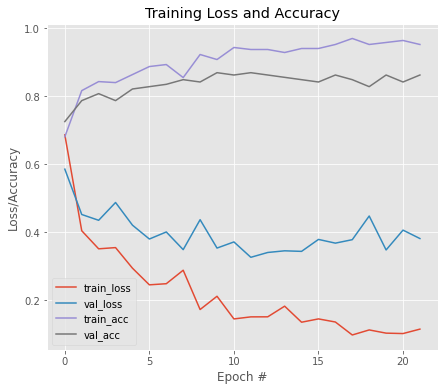


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:10


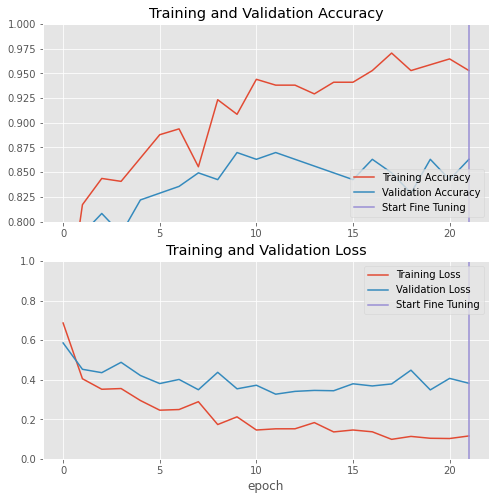

5/5 [==============================] - 2s 133ms/step
Accuracy: 0.8698630136986302
Sensitivity: 0.9468085106382979
AUC:0.8387888707037644


Model  Accuracy  Precision    Recall  \
0  RIMONE_DL_A_True_0.3_0.0001_InceptionV3  0.869863   0.864078  0.946809   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.903553  0.838789     0.946809     0.730769  0.704831

A_False_Split_0.3_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7050
Epoch 1: val_accuracy improved from -inf to 0.73973, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 8s 346ms/step - loss: 0.6214 - accuracy: 0.7050 - val_loss: 0.5960 - val_accuracy: 0.7397
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.8968
Epoch 2: val_accuracy improved from 0.73973 to 0.83562, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 2s 224ms/step - loss: 0.2101 - accuracy: 0.8968 - val_loss: 0.4301 - val_accuracy: 0.8356
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9794
Epoch 3: val_accuracy did not improve from 0.83562
11/11 [==============================] - 2s 173ms/step - loss: 0.0914 - accuracy: 0.9794 - val_loss: 0.4274 - val_accuracy: 0.8356
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss:

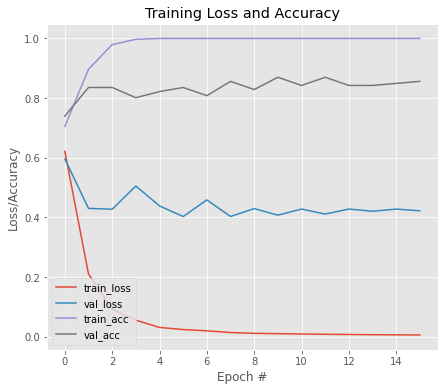


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:10


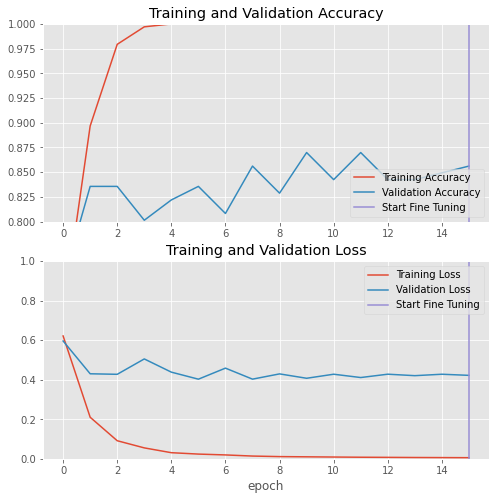

5/5 [==============================] - 2s 126ms/step
Accuracy: 0.8698630136986302
Sensitivity: 0.9361702127659575
AUC:0.8430851063829787


Model  Accuracy  Precision   Recall  \
0  RIMONE_DL_A_False_0.3_0.0001_InceptionV3  0.869863   0.871287  0.93617   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.902564  0.843085      0.93617         0.75  0.707446

In [ ]:
split_ratio = [0.3]
data_aug = [True,False]
learning_rate = [0.0001]
set_seed()
for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_rim_one_dl(width = 299,height = 299)
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{ratio}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL("InceptionV3")
      name = f"RIMONE_DL_A_{aug}_{ratio}_{lr}_InceptionV3"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)

Model  Accuracy  Precision    Recall  \
0    RIM-ONE_v2_A_True_0.1_0.0001_InceptionV3  0.913043   0.875000  0.954545   
1   RIM-ONE_v2_A_False_0.1_0.0001_InceptionV3  0.869565   0.863636  0.863636   
2    RIM-ONE_v2_A_True_0.2_0.0001_InceptionV3  0.945055   0.950000  0.926829   
3   RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077  0.878049   
4    RIM-ONE_v2_A_True_0.3_0.0001_InceptionV3  0.941606   0.931034  0.931034   
5   RIM-ONE_v2_A_False_0.3_0.0001_InceptionV3  0.897810   0.892857  0.862069   
6        ACRIMA_A_True_0.1_0.0001_InceptionV3  0.943662   0.935484  0.935484   
7       ACRIMA_A_False_0.1_0.0001_InceptionV3  0.901408   0.928571  0.838710   
8        ACRIMA_A_True_0.2_0.0001_InceptionV3  0.921986   0.898305  0.913793   
9       ACRIMA_A_False_0.2_0.0001_InceptionV3  0.886525   0.818182  0.931034   
10       ACRIMA_A_True_0.3_0.0001_InceptionV3  0.929245   0.895833  0.945055   
11      ACRIMA_A_False_0.3_0.0001_InceptionV3  0.896226   0.841584  0.934066   
12    RIMONE_DL_A_True_0.3_0.0001_InceptionV3  0.869863   0.864078  0.946809   
13   RIMONE_DL_A_False_0.3_0.0001_InceptionV3  0.869863   0.871287  0.936170   

          F1       AUC  Sensitivity  Specificity     kappa  
0   0.913043  0.914773     0.954545     0.875000  0.826415  
1   0.863636  0.869318     0.863636     0.875000  0.738636  
2   0.938272  0.943415     0.926829     0.960000  0.888780  
3   0.900000  0.909024     0.878049     0.940000  0.821656  
4   0.931034  0.940201     0.931034     0.949367  0.880402  
5   0.877193  0.893060     0.862069     0.924051  0.789739  
6   0.935484  0.942742     0.935484     0.950000  0.885484  
7   0.881356  0.894355     0.838710     0.950000  0.797391  
8   0.905983  0.920752     0.913793     0.927711  0.839325  
9   0.870968  0.893228     0.931034     0.855422  0.770452  
10  0.919786  0.931205     0.945055     0.917355  0.856576  
11  0.885417  0.900917     0.934066     0.867769  0.791058  
12  0.903553  0.838789     0.946809     0.730769  0.704831  
13  0.902564  0.843085     0.936170     0.750000  0.707446

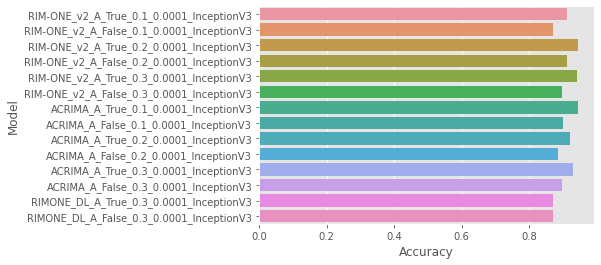

\begin{tabular}{lrrrrrrrr}
\toprule
                                    Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
 RIM-ONE\_v2\_A\_True\_0.1\_0.0001\_InceptionV3 &  0.913043 &   0.875000 & 0.954545 & 0.913043 & 0.914773 &     0.954545 &     0.875000 & 0.826415 \\
RIM-ONE\_v2\_A\_False\_0.1\_0.0001\_InceptionV3 &  0.869565 &   0.863636 & 0.863636 & 0.863636 & 0.869318 &     0.863636 &     0.875000 & 0.738636 \\
 RIM-ONE\_v2\_A\_True\_0.2\_0.0001\_InceptionV3 &  0.945055 &   0.950000 & 0.926829 & 0.938272 & 0.943415 &     0.926829 &     0.960000 & 0.888780 \\
RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.912088 &   0.923077 & 0.878049 & 0.900000 & 0.909024 &     0.878049 &     0.940000 & 0.821656 \\
 RIM-ONE\_v2\_A\_True\_0.3\_0.0001\_InceptionV3 &  0.941606 &   0.931034 & 0.931034 & 0.931034 & 0.940201 &     0.931034 &     0.949367 & 0.880402 \\
RIM-ONE\_v2\_A\_False\_0.3\_0.0001\_InceptionV3 &  0.897810 &

In [ ]:
plot_performance()

ACRIMA DATASET

Height:299 Width:299
A_True_Split_0.1_lr_0.0001
87924736/87910968 [==============================] - 0s 0us/step
Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.7337 - accuracy: 0.6877
Epoch 1: val_accuracy improved from -inf to 0.87324, saving model to InceptionV3_a.hdf5
20/20 [==============================] - 20s 726ms/step - loss: 0.7337 - accuracy: 0.6877 - val_loss: 0.3808 - val_accuracy: 0.8732
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.3450 - accuracy: 0.8596
Epoch 2: val_accuracy did not improve from 0.87324
20/20 [==============================] - 11s 533ms/step - loss: 0.3450 - accuracy: 0.8596 - val_loss: 0.3135 - val_accuracy: 0.8451
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.2942 - accuracy: 0.8675
Epoch 3: val_accuracy improved from 0.87324 to 0.90141, saving model to InceptionV3_a.hdf5
20/20 [==============================] - 12s 588ms/step - loss: 0.2942 - accuracy: 0.8675 - val_loss: 0.2981 - 

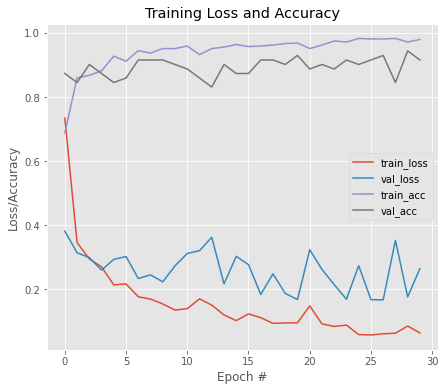


Model Performance Summary:

Best Validation accuracy:0.9436619877815247 at EPOCH:29


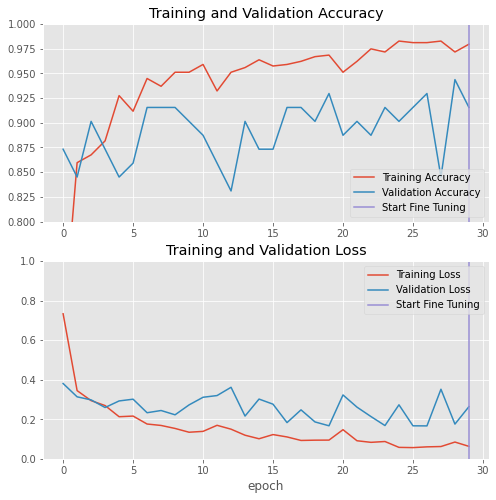

3/3 [==============================] - 1s 135ms/step
Accuracy: 0.9436619718309859
Sensitivity: 0.9354838709677419
AUC:0.942741935483871


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_True_0.1_0.0001_InceptionV3  0.943662   0.935484  0.935484   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.935484  0.942742     0.935484         0.95  0.885484

A_False_Split_0.1_lr_0.0001
Epoch 1/30
20/20 [==============================] - ETA: 0s - loss: 0.7855 - accuracy: 0.6688
Epoch 1: val_accuracy improved from -inf to 0.76056, saving model to InceptionV3_a.hdf5
20/20 [==============================] - 9s 225ms/step - loss: 0.7855 - accuracy: 0.6688 - val_loss: 0.4721 - val_accuracy: 0.7606
Epoch 2/30
20/20 [==============================] - ETA: 0s - loss: 0.2636 - accuracy: 0.8991
Epoch 2: val_accuracy improved from 0.76056 to 0.90141, saving model to InceptionV3_a.hdf5
20/20 [==============================] - 3s 162ms/step - loss: 0.2636 - accuracy: 0.8991 - val_loss: 0.2717 - val_accuracy: 0.9014
Epoch 3/30
20/20 [==============================] - ETA: 0s - loss: 0.1318 - accuracy: 0.9637
Epoch 3: val_accuracy did not improve from 0.90141
20/20 [==============================] - 3s 135ms/step - loss: 0.1318 - accuracy: 0.9637 - val_loss: 0.2757 - val_accuracy: 0.8451
Epoch 4/30
20/20 [==============================] - ETA: 0s - loss:

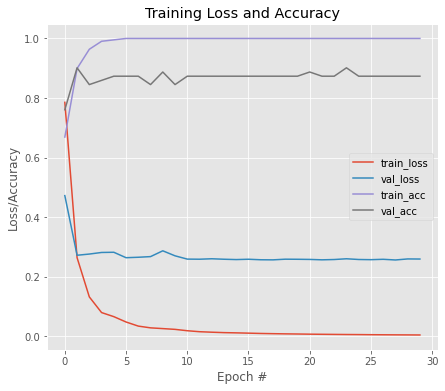


Model Performance Summary:

Best Validation accuracy:0.9014084339141846 at EPOCH:2


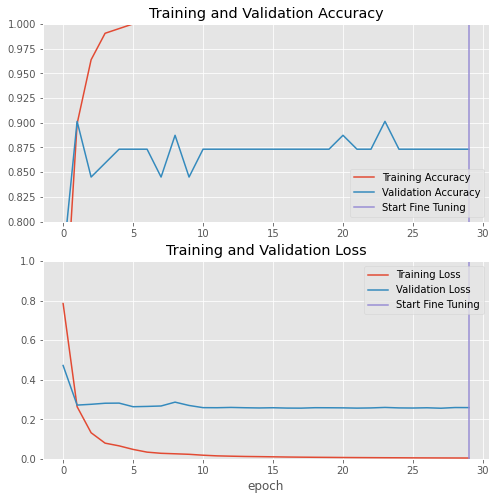

3/3 [==============================] - 1s 151ms/step
Accuracy: 0.9014084507042254
Sensitivity: 0.8387096774193549
AUC:0.8943548387096775


Model  Accuracy  Precision   Recall  \
0  ACRIMA_A_False_0.1_0.0001_InceptionV3  0.901408   0.928571  0.83871   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.881356  0.894355      0.83871         0.95  0.797391

Height:299 Width:299
A_True_Split_0.2_lr_0.0001
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7899 - accuracy: 0.6649
Epoch 1: val_accuracy improved from -inf to 0.78014, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 19s 797ms/step - loss: 0.7899 - accuracy: 0.6649 - val_loss: 0.4577 - val_accuracy: 0.7801
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4215 - accuracy: 0.8121
Epoch 2: val_accuracy improved from 0.78014 to 0.79433, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 11s 586ms/step - loss: 0.4215 - accuracy: 0.8121 - val_loss: 0.4288 - val_accuracy: 0.7943
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.3185 - accuracy: 0.8723
Epoch 3: val_accuracy did not improve from 0.79433
18/18 [==============================] - 10s 539ms/step - loss: 0.3185 - accuracy: 0.8723 - val_loss: 0.5175 - val_accuracy: 0.7730
Epoch 4/30
18/18 [==========================

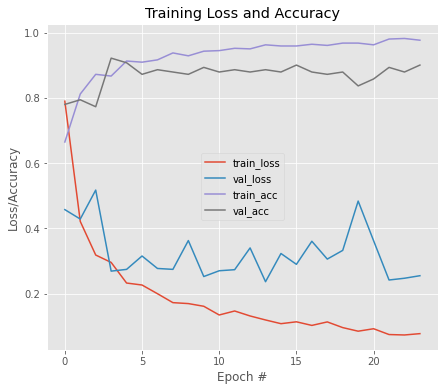


Model Performance Summary:

Best Validation accuracy:0.9219858050346375 at EPOCH:4


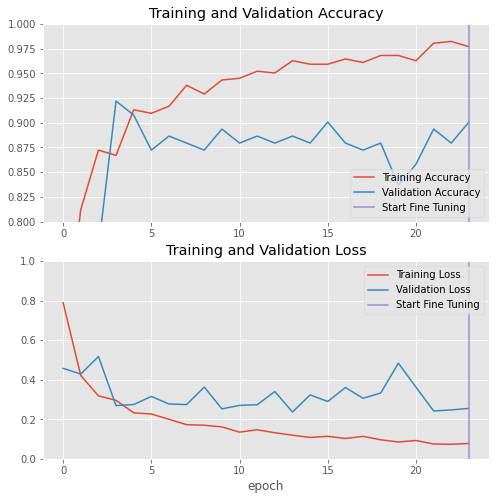

5/5 [==============================] - 2s 123ms/step
Accuracy: 0.9219858156028369
Sensitivity: 0.9137931034482759
AUC:0.9207519734108849


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_True_0.2_0.0001_InceptionV3  0.921986   0.898305  0.913793   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.905983  0.920752     0.913793     0.927711  0.839325

A_False_Split_0.2_lr_0.0001
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.6702
Epoch 1: val_accuracy improved from -inf to 0.79433, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 9s 255ms/step - loss: 0.7886 - accuracy: 0.6702 - val_loss: 0.4324 - val_accuracy: 0.7943
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9167
Epoch 2: val_accuracy improved from 0.79433 to 0.85106, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 3s 190ms/step - loss: 0.2329 - accuracy: 0.9167 - val_loss: 0.3294 - val_accuracy: 0.8511
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9823
Epoch 3: val_accuracy did not improve from 0.85106
18/18 [==============================] - 3s 152ms/step - loss: 0.1186 - accuracy: 0.9823 - val_loss: 0.3554 - val_accuracy: 0.8298
Epoch 4/30
18/18 [==============================] - ETA: 0s - loss:

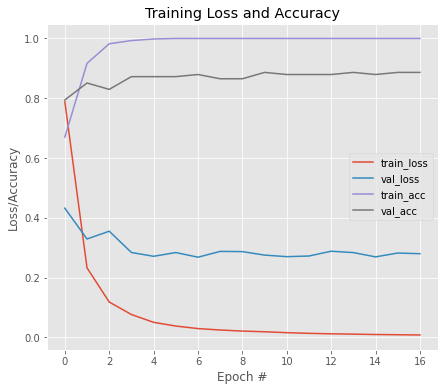


Model Performance Summary:

Best Validation accuracy:0.8865247964859009 at EPOCH:10


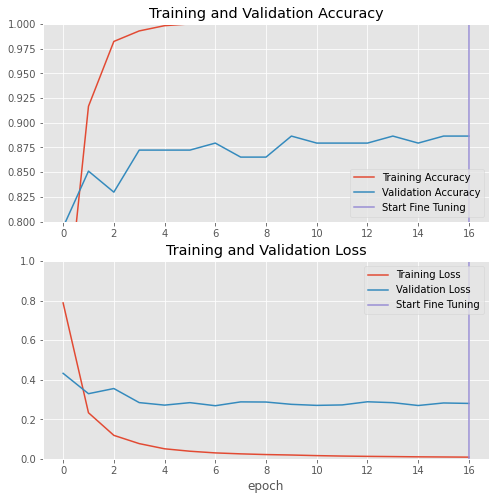

5/5 [==============================] - 2s 130ms/step
Accuracy: 0.8865248226950354
Sensitivity: 0.9310344827586207
AUC:0.8932280847528042


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.2_0.0001_InceptionV3  0.886525   0.818182  0.931034   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.870968  0.893228     0.931034     0.855422  0.770452

Height:299 Width:299
A_True_Split_0.3_lr_0.0001
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.9251 - accuracy: 0.6024
Epoch 1: val_accuracy improved from -inf to 0.78774, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 15s 680ms/step - loss: 0.9251 - accuracy: 0.6024 - val_loss: 0.4924 - val_accuracy: 0.7877
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.4620 - accuracy: 0.7809
Epoch 2: val_accuracy improved from 0.78774 to 0.83491, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 10s 595ms/step - loss: 0.4620 - accuracy: 0.7809 - val_loss: 0.3666 - val_accuracy: 0.8349
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.3850 - accuracy: 0.8215
Epoch 3: val_accuracy improved from 0.83491 to 0.84906, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 10s 603ms/step - loss: 0.3850 - accuracy: 0.8215 - val_loss: 0.3621 - val_accuracy: 0.8491
Epoc

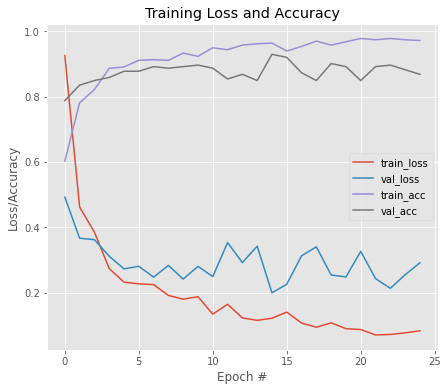


Model Performance Summary:

Best Validation accuracy:0.9292452931404114 at EPOCH:15


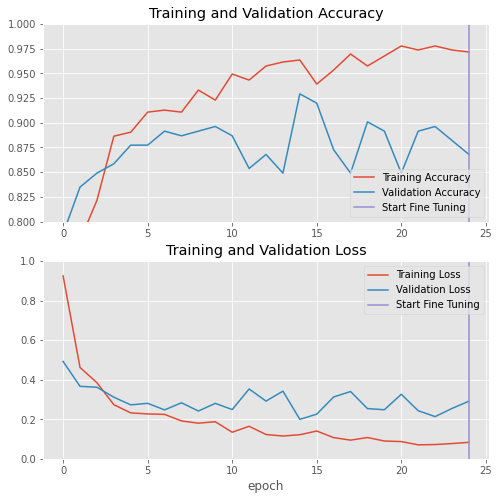

7/7 [==============================] - 2s 120ms/step
Accuracy: 0.9292452830188679
Sensitivity: 0.945054945054945
AUC:0.9312051584778858


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_True_0.3_0.0001_InceptionV3  0.929245   0.895833  0.945055   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.919786  0.931205     0.945055     0.917355  0.856576

A_False_Split_0.3_lr_0.0001
Epoch 1/30
16/16 [==============================] - ETA: 0s - loss: 0.9594 - accuracy: 0.5882
Epoch 1: val_accuracy improved from -inf to 0.80660, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 9s 282ms/step - loss: 0.9594 - accuracy: 0.5882 - val_loss: 0.4488 - val_accuracy: 0.8066
Epoch 2/30
16/16 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.8215
Epoch 2: val_accuracy improved from 0.80660 to 0.84906, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 3s 208ms/step - loss: 0.3654 - accuracy: 0.8215 - val_loss: 0.3483 - val_accuracy: 0.8491
Epoch 3/30
16/16 [==============================] - ETA: 0s - loss: 0.2261 - accuracy: 0.8925
Epoch 3: val_accuracy improved from 0.84906 to 0.89151, saving model to InceptionV3_a.hdf5
16/16 [==============================] - 3s 203ms/step - loss: 0.2261 - accuracy: 0.8925 - val_loss: 0.2791 - val_accuracy: 0.8915
Epoch 4/30
16/16 [=========

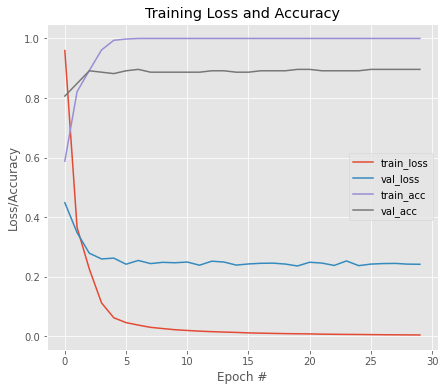


Model Performance Summary:

Best Validation accuracy:0.8962264060974121 at EPOCH:7


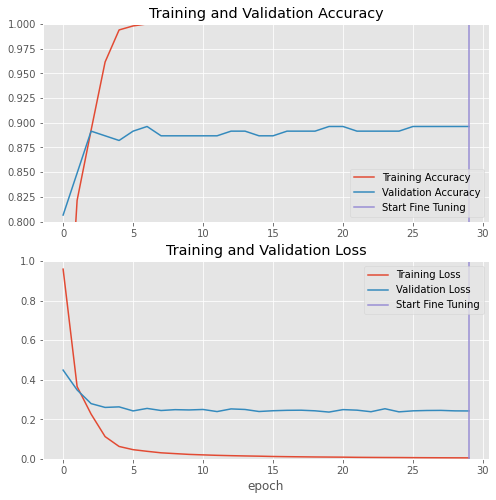

7/7 [==============================] - 2s 123ms/step
Accuracy: 0.8962264150943396
Sensitivity: 0.9340659340659341
AUC:0.9009172645536282


Model  Accuracy  Precision    Recall  \
0  ACRIMA_A_False_0.3_0.0001_InceptionV3  0.896226   0.841584  0.934066   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.885417  0.900917     0.934066     0.867769  0.791058

In [ ]:
split_ratio = [0.1,0.2,0.3]
data_aug = [True,False]
learning_rate = [0.0001]
set_seed()
for ratio in split_ratio:
  (trainx,trainy),(testx,testy) = get_acrima_dataset(width = 299,height = 299,test_train_ratio = ratio)
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{ratio}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL("InceptionV3")
      name = f"ACRIMA_A_{aug}_{ratio}_{lr}_InceptionV3"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)

Model  Accuracy  Precision    Recall  \
0    RIM-ONE_v2_A_True_0.1_0.0001_InceptionV3  0.913043   0.875000  0.954545   
1   RIM-ONE_v2_A_False_0.1_0.0001_InceptionV3  0.869565   0.863636  0.863636   
2    RIM-ONE_v2_A_True_0.2_0.0001_InceptionV3  0.945055   0.950000  0.926829   
3   RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077  0.878049   
4    RIM-ONE_v2_A_True_0.3_0.0001_InceptionV3  0.941606   0.931034  0.931034   
5   RIM-ONE_v2_A_False_0.3_0.0001_InceptionV3  0.897810   0.892857  0.862069   
6        ACRIMA_A_True_0.1_0.0001_InceptionV3  0.943662   0.935484  0.935484   
7       ACRIMA_A_False_0.1_0.0001_InceptionV3  0.901408   0.928571  0.838710   
8        ACRIMA_A_True_0.2_0.0001_InceptionV3  0.921986   0.898305  0.913793   
9       ACRIMA_A_False_0.2_0.0001_InceptionV3  0.886525   0.818182  0.931034   
10       ACRIMA_A_True_0.3_0.0001_InceptionV3  0.929245   0.895833  0.945055   
11      ACRIMA_A_False_0.3_0.0001_InceptionV3  0.896226   0.841584  0.934066   

          F1       AUC  Sensitivity  Specificity     kappa  
0   0.913043  0.914773     0.954545     0.875000  0.826415  
1   0.863636  0.869318     0.863636     0.875000  0.738636  
2   0.938272  0.943415     0.926829     0.960000  0.888780  
3   0.900000  0.909024     0.878049     0.940000  0.821656  
4   0.931034  0.940201     0.931034     0.949367  0.880402  
5   0.877193  0.893060     0.862069     0.924051  0.789739  
6   0.935484  0.942742     0.935484     0.950000  0.885484  
7   0.881356  0.894355     0.838710     0.950000  0.797391  
8   0.905983  0.920752     0.913793     0.927711  0.839325  
9   0.870968  0.893228     0.931034     0.855422  0.770452  
10  0.919786  0.931205     0.945055     0.917355  0.856576  
11  0.885417  0.900917     0.934066     0.867769  0.791058

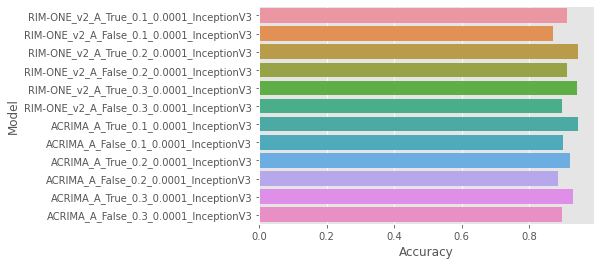

\begin{tabular}{lrrrrrrrr}
\toprule
                                    Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
 RIM-ONE\_v2\_A\_True\_0.1\_0.0001\_InceptionV3 &  0.913043 &   0.875000 & 0.954545 & 0.913043 & 0.914773 &     0.954545 &     0.875000 & 0.826415 \\
RIM-ONE\_v2\_A\_False\_0.1\_0.0001\_InceptionV3 &  0.869565 &   0.863636 & 0.863636 & 0.863636 & 0.869318 &     0.863636 &     0.875000 & 0.738636 \\
 RIM-ONE\_v2\_A\_True\_0.2\_0.0001\_InceptionV3 &  0.945055 &   0.950000 & 0.926829 & 0.938272 & 0.943415 &     0.926829 &     0.960000 & 0.888780 \\
RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.912088 &   0.923077 & 0.878049 & 0.900000 & 0.909024 &     0.878049 &     0.940000 & 0.821656 \\
 RIM-ONE\_v2\_A\_True\_0.3\_0.0001\_InceptionV3 &  0.941606 &   0.931034 & 0.931034 & 0.931034 & 0.940201 &     0.931034 &     0.949367 & 0.880402 \\
RIM-ONE\_v2\_A\_False\_0.3\_0.0001\_InceptionV3 &  0.897810 &

In [ ]:
plot_performance()

# Model Performance

In [ ]:
MODEL_LIST = ['vgg16','vgg19','resnet50','DenseNet121','MobileNet','InceptionV3','InceptionResNetV2','xception']

In [ ]:
(trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = 0.1)

Height:299 Width:299


Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.7178 - accuracy: 0.5440
Epoch 1: val_accuracy improved from -inf to 0.67033, saving model to vgg16_a.hdf5
12/12 [==============================] - 3s 224ms/step - loss: 0.7178 - accuracy: 0.5440 - val_loss: 0.6197 - val_accuracy: 0.6703
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.6731
Epoch 2: val_accuracy improved from 0.67033 to 0.69231, saving model to vgg16_a.hdf5
12/12 [==============================] - 2s 202ms/step - loss: 0.6105 - accuracy: 0.6731 - val_loss: 0.5916 - val_accuracy: 0.6923
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.5754 - accuracy: 0.6868
Epoch 3: val_accuracy improved from 0.69231 to 0.72527, saving model to vgg16_a.hdf5
12/12 [==============================] - 2s 204ms/step - loss: 0.5754 - accuracy: 0.6868 - val_loss: 0.5656 - val_accuracy: 0.7253
Epo

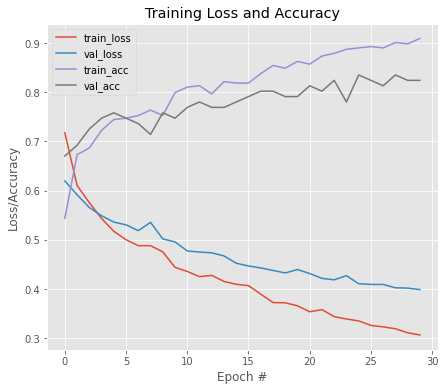


Model Performance Summary:

Best Validation accuracy:0.8351648449897766 at EPOCH:25


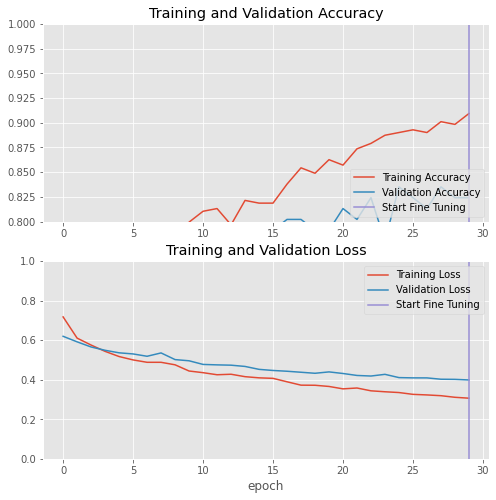

3/3 [==============================] - 0s 146ms/step
Accuracy: 0.8351648351648352
Sensitivity: 0.7560975609756098
AUC:0.828048780487805


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.835165   0.861111  0.756098   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.805195  0.828049     0.756098          0.9  0.663379

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.6730 - accuracy: 0.5467
Epoch 1: val_accuracy improved from -inf to 0.62637, saving model to vgg19_a.hdf5
12/12 [==============================] - 4s 262ms/step - loss: 0.6730 - accuracy: 0.5467 - val_loss: 0.6614 - val_accuracy: 0.6264
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.6070 - accuracy: 0.6676
Epoch 2: val_accuracy improved from 0.62637 to 0.69231, saving model to vgg19_a.hdf5
12/12 [==============================] - 3s 242ms/step - loss: 0.6070 - accuracy: 0.6676 - val_loss: 0.6093 - val_accuracy: 0.6923
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.7198
Epoch 3: val_accuracy did not improve from 0.69231
12/12 [==============================] - 3s 222ms/step - loss: 0.5700 - accuracy: 0.7198 - val_loss: 0.5913 - val_accuracy: 0.6813
Epoch 4/30
12/12 [===================

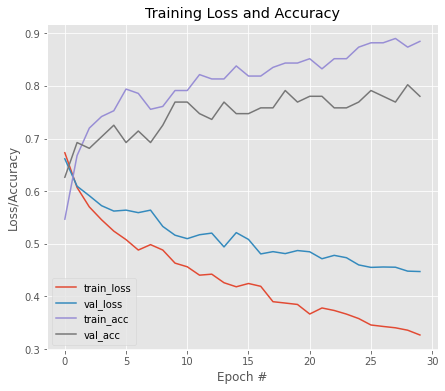


Model Performance Summary:

Best Validation accuracy:0.8021978139877319 at EPOCH:29


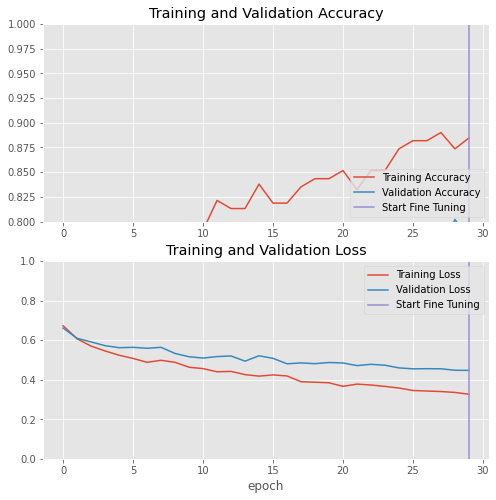

3/3 [==============================] - 1s 182ms/step
Accuracy: 0.8021978021978022
Sensitivity: 0.7560975609756098
AUC:0.7980487804878049


Model  Accuracy  Precision    Recall     F1  \
0  RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.802198   0.794872  0.756098  0.775   

        AUC  Sensitivity  Specificity     Kappa  
0  0.798049     0.756098         0.84  0.598726

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.7534 - accuracy: 0.5165
Epoch 1: val_accuracy improved from -inf to 0.54945, saving model to resnet50_a.hdf5
12/12 [==============================] - 7s 348ms/step - loss: 0.7534 - accuracy: 0.5165 - val_loss: 0.6881 - val_accuracy: 0.5495
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.7356 - accuracy: 0.5082
Epoch 2: val_accuracy did not improve from 0.54945
12/12 [==============================] - 2s 124ms/step - loss: 0.7356 - accuracy: 0.5082 - val_loss: 0.7284 - val_accuracy: 0.5495
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.7257 - accuracy: 0.5192
Epoch 3: val_accuracy did not improve from 0.54945
12/12 [==============================] - 2s 125ms/step - loss: 0.7257 - accuracy: 0.5192 - val_loss: 0.7211 - val_accuracy: 0.5495
Epoch 4/30
12/12 [==============================] - ETA: 0s - loss: 

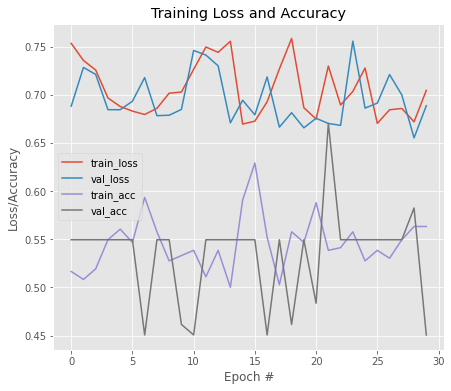


Model Performance Summary:

Best Validation accuracy:0.6703296899795532 at EPOCH:22


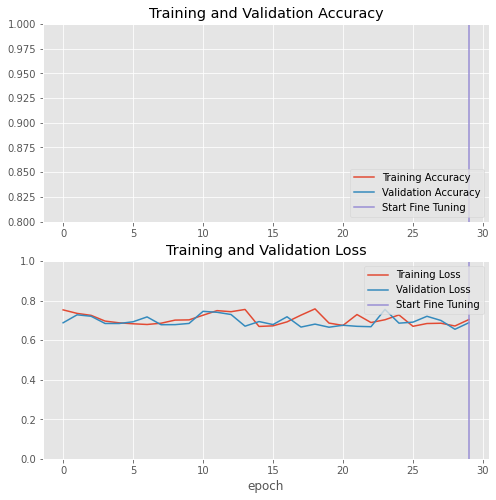

3/3 [==============================] - 1s 108ms/step
Accuracy: 0.6703296703296703
Sensitivity: 0.9024390243902439
AUC:0.6912195121951219


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_resnet50   0.67033   0.587302  0.902439   

         F1      AUC  Sensitivity  Specificity     Kappa  
0  0.711538  0.69122     0.902439         0.48  0.364821

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.8448 - accuracy: 0.6181
Epoch 1: val_accuracy improved from -inf to 0.65934, saving model to DenseNet121_a.hdf5
12/12 [==============================] - 13s 557ms/step - loss: 0.8448 - accuracy: 0.6181 - val_loss: 0.6820 - val_accuracy: 0.6593
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.3975 - accuracy: 0.7940
Epoch 2: val_accuracy improved from 0.65934 to 0.70330, saving model to DenseNet121_a.hdf5
12/12 [==============================] - 2s 176ms/step - loss: 0.3975 - accuracy: 0.7940 - val_loss: 0.5740 - val_accuracy: 0.7033
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.2914 - accuracy: 0.8764
Epoch 3: val_accuracy improved from 0.70330 to 0.71429, saving model to DenseNet121_a.hdf5
12/12 [==============================] - 2s 179ms/step - loss: 0.2914 - accuracy: 0.8764 - val_loss: 0.5528 - val_a

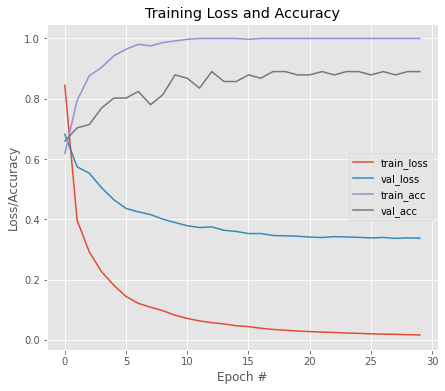


Model Performance Summary:

Best Validation accuracy:0.8901098966598511 at EPOCH:13


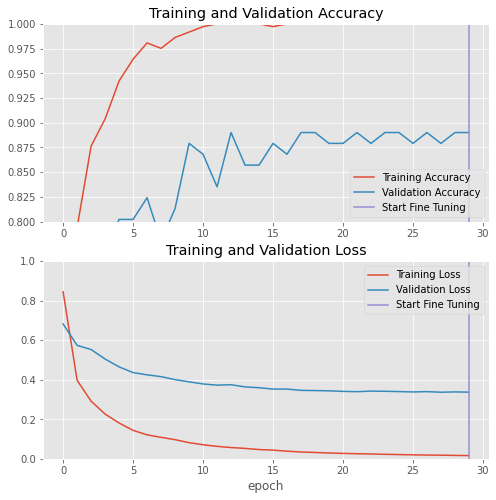

3/3 [==============================] - 2s 109ms/step
Accuracy: 0.8901098901098901
Sensitivity: 0.9024390243902439
AUC:0.891219512195122


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121   0.89011   0.860465  0.902439   

         F1      AUC  Sensitivity  Specificity     Kappa  
0  0.880952  0.89122     0.902439         0.88  0.779019

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/12 [==========================>...] - ETA: 0s - loss: 0.5746 - accuracy: 0.7530
Epoch 1: val_accuracy improved from -inf to 0.83516, saving model to MobileNet_a.hdf5
12/12 [==============================] - 3s 154ms/step - loss: 0.5620 - accuracy: 0.7637 - val_loss: 0.4810 - val_accuracy: 0.8352
Epoch 2/30
11/12 [==========================>...] - ETA: 0s - loss: 0.2173 - accuracy: 0.9036
Epoch 2: val_accuracy improved from 0.83516 to 0.86813, saving model to MobileNet_a.hdf5
12/12 [==============================] - 1s 68ms/step - loss: 0.2001 - accuracy: 0.9121 - val_loss: 0.4531 - val_accuracy: 0.8681
Epoch 3/30
11/12 [==========================>...] - ETA: 0s - loss: 0.0830 - accuracy: 0.9819
Epoch 3: val_accuracy improved from 0.86813 to 0.87912, saving model to MobileNet_a.hdf5
12/12 [==============================] - 1s 68ms/step - loss: 0.0799 - accuracy: 0.9835 - val_loss: 0.4598 - val_accuracy: 

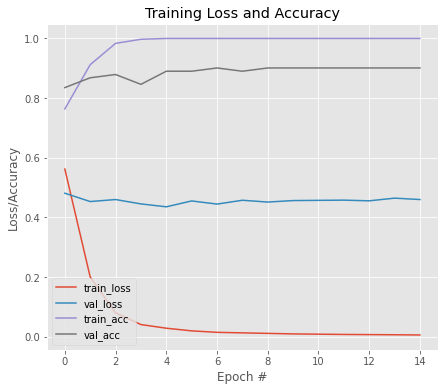


Model Performance Summary:

Best Validation accuracy:0.901098906993866 at EPOCH:7


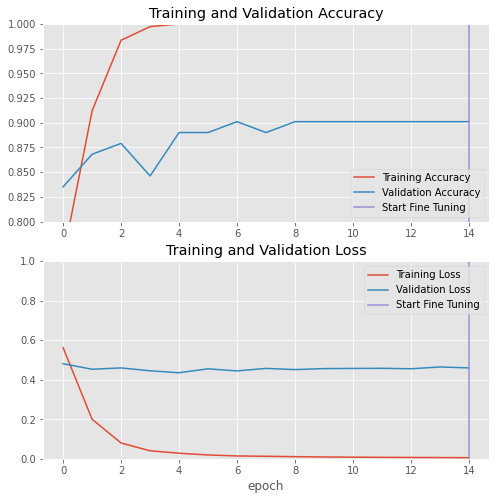

3/3 [==============================] - 0s 34ms/step
Accuracy: 0.9010989010989011
Sensitivity: 0.8536585365853658
AUC:0.8968292682926828


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.901099   0.921053  0.853659   

         F1       AUC  Sensitivity  Specificity    Kappa  
0  0.886076  0.896829     0.853659         0.94  0.79892

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.6016
Epoch 1: val_accuracy improved from -inf to 0.72527, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 8s 338ms/step - loss: 0.9623 - accuracy: 0.6016 - val_loss: 0.6179 - val_accuracy: 0.7253
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8654
Epoch 2: val_accuracy improved from 0.72527 to 0.86813, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 2s 195ms/step - loss: 0.3237 - accuracy: 0.8654 - val_loss: 0.4678 - val_accuracy: 0.8681
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.1623 - accuracy: 0.9313
Epoch 3: val_accuracy improved from 0.86813 to 0.90110, saving model to InceptionV3_a.hdf5
12/12 [==============================] - 2s 196ms/step - loss: 0.1623 - accuracy: 0.9313 - val_loss: 0.3309 - val_ac

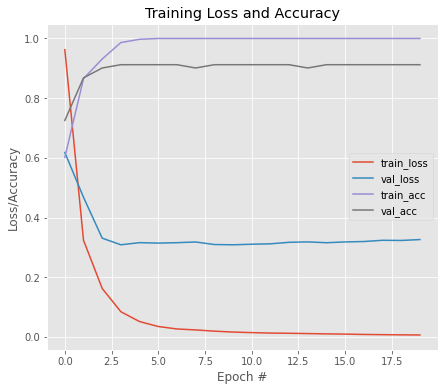


Model Performance Summary:

Best Validation accuracy:0.9120879173278809 at EPOCH:4


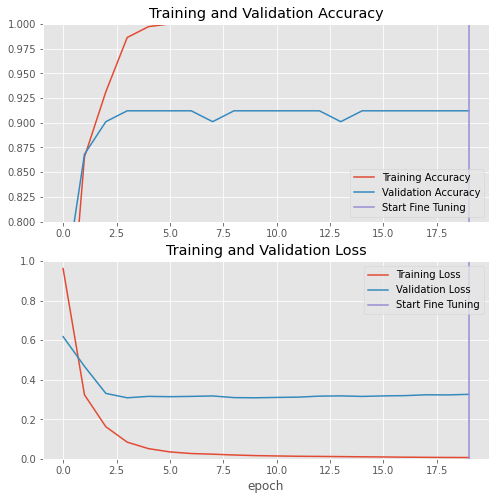

3/3 [==============================] - 2s 150ms/step
Accuracy: 0.9120879120879121
Sensitivity: 0.8780487804878049
AUC:0.9090243902439024


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077  0.878049   

    F1       AUC  Sensitivity  Specificity     Kappa  
0  0.9  0.909024     0.878049         0.94  0.821656

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.5824
Epoch 1: val_accuracy improved from -inf to 0.63736, saving model to InceptionResNetV2_a.hdf5
12/12 [==============================] - 22s 1s/step - loss: 0.7040 - accuracy: 0.5824 - val_loss: 0.6861 - val_accuracy: 0.6374
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.4114 - accuracy: 0.8242
Epoch 2: val_accuracy improved from 0.63736 to 0.67033, saving model to InceptionResNetV2_a.hdf5
12/12 [==============================] - 6s 510ms/step - loss: 0.4114 - accuracy: 0.8242 - val_loss: 0.6285 - val_accuracy: 0.6703
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.2988 - accuracy: 0.8819
Epoch 3: val_accuracy improved from 0.67033 to 0.75824, saving model to InceptionResNetV2_a.hdf5
12/12 [==============================] - 6s 518ms/step - loss: 0.2988 - accuracy: 0.8819 - val_loss:

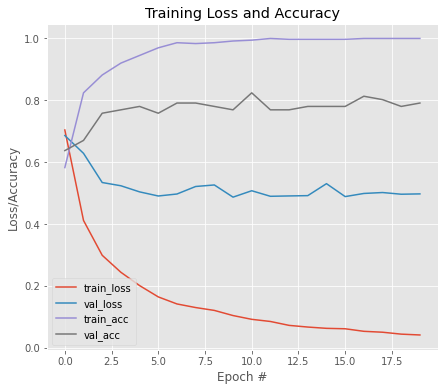


Model Performance Summary:

Best Validation accuracy:0.8241758346557617 at EPOCH:11


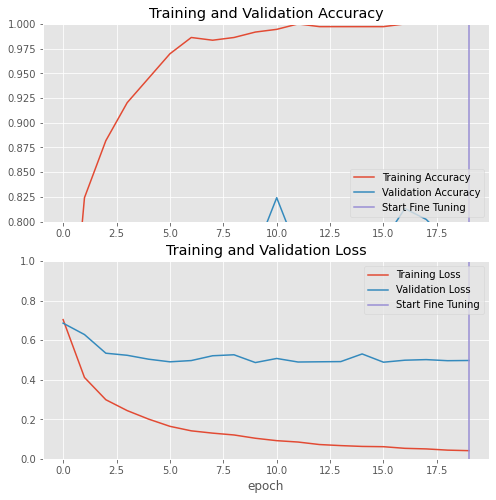

3/3 [==============================] - 4s 320ms/step
Accuracy: 0.8241758241758241
Sensitivity: 0.8780487804878049
AUC:0.8290243902439024


Model  Accuracy  Precision  \
0  RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.824176   0.765957   

     Recall        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.878049  0.818182  0.829024     0.878049         0.78  0.649494

Height:299 Width:299 test_train_ratio:0.2
A_False_Split_0.2_lr_0.0001
Epoch 1/30
12/12 [==============================] - ETA: 0s - loss: 0.6686 - accuracy: 0.6401
Epoch 1: val_accuracy improved from -inf to 0.72527, saving model to xception_a.hdf5
12/12 [==============================] - 9s 546ms/step - loss: 0.6686 - accuracy: 0.6401 - val_loss: 0.5987 - val_accuracy: 0.7253
Epoch 2/30
12/12 [==============================] - ETA: 0s - loss: 0.3407 - accuracy: 0.8571
Epoch 2: val_accuracy improved from 0.72527 to 0.78022, saving model to xception_a.hdf5
12/12 [==============================] - 4s 328ms/step - loss: 0.3407 - accuracy: 0.8571 - val_loss: 0.5429 - val_accuracy: 0.7802
Epoch 3/30
12/12 [==============================] - ETA: 0s - loss: 0.2309 - accuracy: 0.8984
Epoch 3: val_accuracy improved from 0.78022 to 0.84615, saving model to xception_a.hdf5
12/12 [==============================] - 4s 327ms/step - loss: 0.2309 - accuracy: 0.8984 - val_loss: 0.4336 - val_accuracy: 0

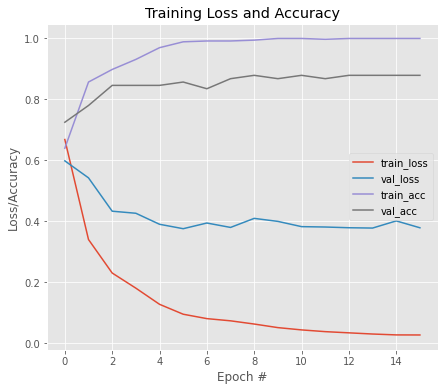


Model Performance Summary:

Best Validation accuracy:0.8791208863258362 at EPOCH:9


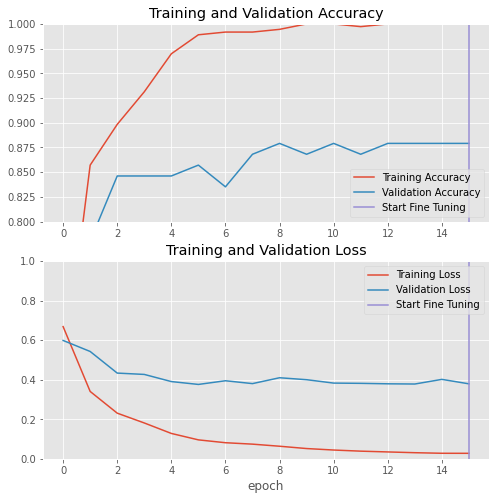

3/3 [==============================] - 1s 260ms/step
Accuracy: 0.8791208791208791
Sensitivity: 0.7804878048780488
AUC:0.8702439024390244


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.2_0.0001_xception  0.879121   0.941176  0.780488   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.853333  0.870244     0.780488         0.96  0.752044

In [ ]:
split_ratio = [0.2]
data_aug = [False]
learning_rate = [0.0001]
set_seed()
for model in MODEL_LIST:
  (trainx,trainy),(testx,testy) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = split_ratio[-1])
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{split_ratio[-1]}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL(model)
      name = f"RIM-ONE_v2_A_{aug}_{split_ratio[-1]}_{lr}_{model}"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)

Model  Accuracy  Precision  \
3         RIM-ONE_v2_A_False_0.2_0.0001_InceptionV3  0.912088   0.923077   
23              RIM-ONE_v2_A_False_0.2_0.0001_vgg16  0.835165   0.861111   
24              RIM-ONE_v2_A_False_0.2_0.0001_vgg19  0.802198   0.794872   
25           RIM-ONE_v2_A_False_0.2_0.0001_resnet50  0.670330   0.587302   
26        RIM-ONE_v2_A_False_0.2_0.0001_DenseNet121  0.890110   0.860465   
27          RIM-ONE_v2_A_False_0.2_0.0001_MobileNet  0.901099   0.921053   
28  RIM-ONE_v2_A_False_0.2_0.0001_InceptionResNetV2  0.824176   0.765957   
29           RIM-ONE_v2_A_False_0.2_0.0001_xception  0.879121   0.941176   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
3   0.878049  0.900000  0.909024     0.878049         0.94  0.821656  
23  0.756098  0.805195  0.828049     0.756098         0.90  0.663379  
24  0.756098  0.775000  0.798049     0.756098         0.84  0.598726  
25  0.902439  0.711538  0.691220     0.902439         0.48  0.364821  
26  0.902439  0.880952  0.891220     0.902439         0.88  0.779019  
27  0.853659  0.886076  0.896829     0.853659         0.94  0.798920  
28  0.878049  0.818182  0.829024     0.878049         0.78  0.649494  
29  0.780488  0.853333  0.870244     0.780488         0.96  0.752044

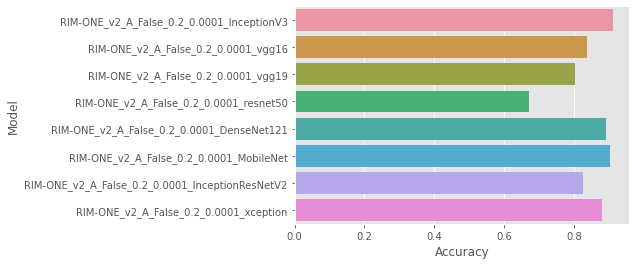

\begin{tabular}{lrrrrrrrr}
\toprule
                                          Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
      RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.912088 &   0.923077 & 0.878049 & 0.900000 & 0.909024 &     0.878049 &         0.94 & 0.821656 \\
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg16 &  0.835165 &   0.861111 & 0.756098 & 0.805195 & 0.828049 &     0.756098 &         0.90 & 0.663379 \\
            RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_vgg19 &  0.802198 &   0.794872 & 0.756098 & 0.775000 & 0.798049 &     0.756098 &         0.84 & 0.598726 \\
         RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_resnet50 &  0.670330 &   0.587302 & 0.902439 & 0.711538 & 0.691220 &     0.902439 &         0.48 & 0.364821 \\
      RIM-ONE\_v2\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.890110 &   0.860465 & 0.902439 & 0.880952 & 0.891220 &     0.902439 &         0.88 & 0.779019 \\
        RIM-ONE\_v2\_A\_F

In [ ]:
plot_performance('RIM-ONE_v2_A_False_0.2_0.0001')

ACRIMA DATASET

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
58900480/58889256 [==============================] - 1s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7199 - accuracy: 0.5461
Epoch 1: val_loss improved from inf to 0.64667, saving model to vgg16_a.hdf5
18/18 [==============================] - 8s 382ms/step - loss: 0.7199 - accuracy: 0.5461 - val_loss: 0.6467 - val_accuracy: 0.7163
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.5953 - accuracy: 0.7234
Epoch 2: val_loss improved from 0.64667 to 0.56192, saving model to vgg16_a.hdf5
18/18 [==============================] - 3s 191ms/step - loss: 0.5953 - accuracy: 0.7234 - val_loss: 0.5619 - val_accuracy: 0.8369
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.5266 - accuracy: 0.8174
Epoch 3: val_loss improved from 0.56192 to 0.51203, saving model to vgg16_a.hdf5
18/18 [==============================] - 4s 199ms/step - loss: 0.5266 - accuracy: 0.8174 - val_loss: 0.

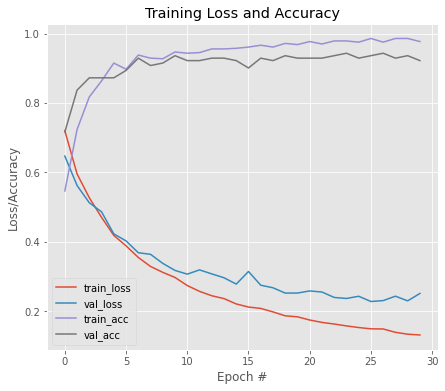


Model Performance Summary:

Best Validation accuracy:0.9432623982429504 at EPOCH:24


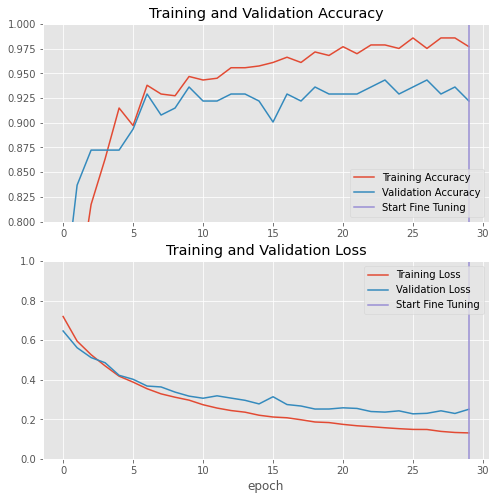

5/5 [==============================] - 1s 145ms/step
Accuracy: 0.9361702127659575
Sensitivity: 0.9482758620689655
AUC:0.9379933527212297


Model  Accuracy  Precision    Recall       F1  \
0  EN_ACRIMA_A_False_0.2_0.0001_vgg16   0.93617   0.901639  0.948276  0.92437   

        AUC  Sensitivity  Specificity     Kappa  
0  0.937993     0.948276     0.927711  0.869216

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
80150528/80134624 [==============================] - 1s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6914 - accuracy: 0.5621
Epoch 1: val_loss improved from inf to 0.62423, saving model to vgg19_a.hdf5
18/18 [==============================] - 5s 244ms/step - loss: 0.6914 - accuracy: 0.5621 - val_loss: 0.6242 - val_accuracy: 0.6383
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.5916 - accuracy: 0.7553
Epoch 2: val_loss improved from 0.62423 to 0.56448, saving model to vgg19_a.hdf5
18/18 [==============================] - 4s 236ms/step - loss: 0.5916 - accuracy: 0.7553 - val_loss: 0.5645 - val_accuracy: 0.7163
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.5295 - accuracy: 0.8174
Epoch 3: val_loss improved from 0.56448 to 0.53173, saving model to vgg19_a.hdf5
18/18 [==============================] - 4s 238ms/step - loss: 0.5295 - accuracy: 0.8174 - val_loss: 0.

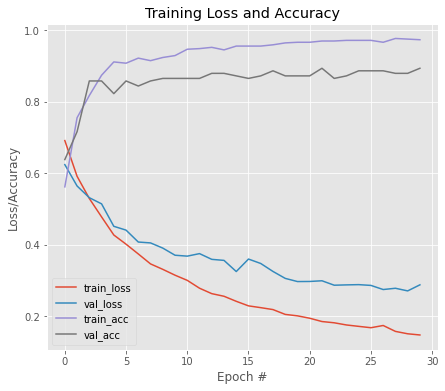


Model Performance Summary:

Best Validation accuracy:0.8936170339584351 at EPOCH:22


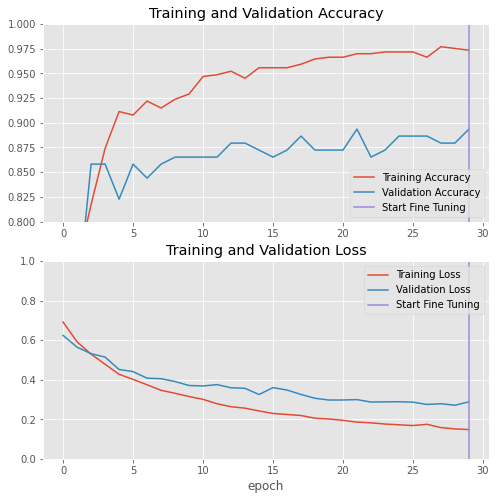

5/5 [==============================] - 1s 178ms/step
Accuracy: 0.8794326241134752
Sensitivity: 0.8620689655172413
AUC:0.8768176152887411


Model  Accuracy  Precision    Recall  \
0  EN_ACRIMA_A_False_0.2_0.0001_vgg19  0.879433   0.847458  0.862069   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.854701  0.876818     0.862069     0.891566  0.751683

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
29097984/29084464 [==============================] - 0s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7716 - accuracy: 0.6312
Epoch 1: val_loss improved from inf to 0.46342, saving model to DenseNet121_a.hdf5
18/18 [==============================] - 14s 400ms/step - loss: 0.7716 - accuracy: 0.6312 - val_loss: 0.4634 - val_accuracy: 0.7943
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2886 - accuracy: 0.8777
Epoch 2: val_loss improved from 0.46342 to 0.33572, saving model to DenseNet121_a.hdf5
18/18 [==============================] - 3s 157ms/step - loss: 0.2886 - accuracy: 0.8777 - val_loss: 0.3357 - val_accuracy: 0.8369
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9397
Epoch 3: val_loss improved from 0.33572 to 0.30751, saving model to DenseNet121_a.hdf5
18/18 [==============================] - 3s 159ms/step - loss: 0.1775 - accuracy: 0.

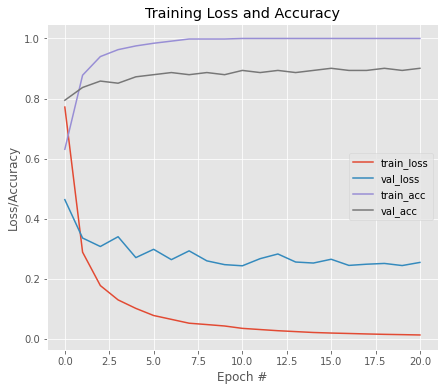


Model Performance Summary:

Best Validation accuracy:0.9007092118263245 at EPOCH:16


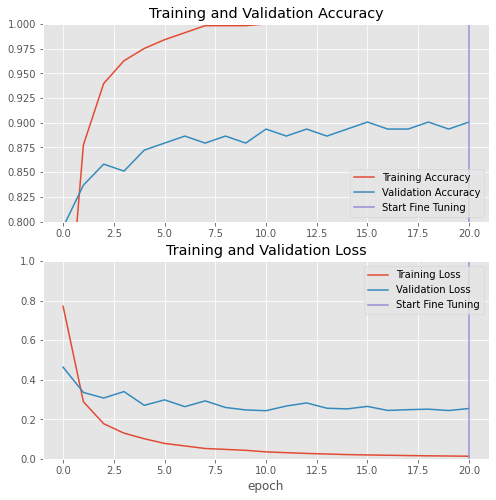

5/5 [==============================] - 2s 107ms/step
Accuracy: 0.8936170212765957
Sensitivity: 0.9137931034482759
AUC:0.8966555878687162


Model  Accuracy  Precision    Recall  \
0  EN_ACRIMA_A_False_0.2_0.0001_DenseNet121  0.893617    0.84127  0.913793   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.876033  0.896656     0.913793     0.879518  0.783144

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
17235968/17225924 [==============================] - 0s 0us/step
Epoch 1/30
17/18 [===========================>..] - ETA: 0s - loss: 0.7119 - accuracy: 0.6598
Epoch 1: val_loss improved from inf to 0.51310, saving model to MobileNet_a.hdf5
18/18 [==============================] - 4s 114ms/step - loss: 0.6981 - accuracy: 0.6649 - val_loss: 0.5131 - val_accuracy: 0.8014
Epoch 2/30
17/18 [===========================>..] - ETA: 0s - loss: 0.2341 - accuracy: 0.9079
Epoch 2: val_loss improved from 0.51310 to 0.39476, saving model to MobileNet_a.hdf5
18/18 [==============================] - 1s 62ms/step - loss: 0.2397 - accuracy: 0.9043 - val_loss: 0.3948 - val_accuracy: 0.8794
Epoch 3/30
17/18 [===========================>..] - ETA: 0s - loss: 0.1282 - accuracy: 0.9651
Epoch 3: val_loss improved from 0.39476 to 0.35914, saving model to MobileNet_a.hdf5
18/18 [==============================] - 1s 62ms/step - loss: 0.1266 - accuracy: 0.9663 - va

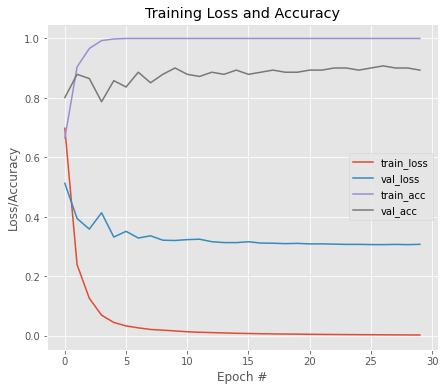


Model Performance Summary:

Best Validation accuracy:0.9078013896942139 at EPOCH:27


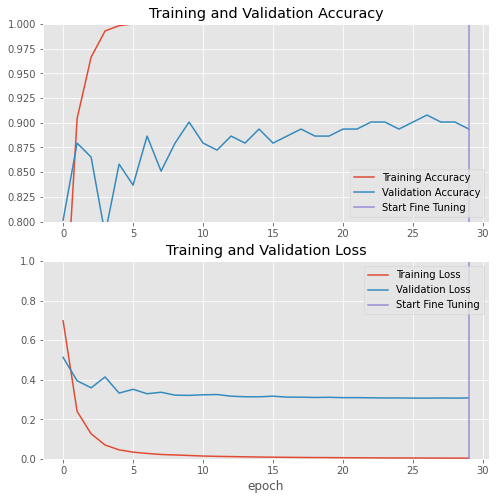

5/5 [==============================] - 1s 33ms/step
Accuracy: 0.9078014184397163
Sensitivity: 0.8620689655172413
AUC:0.9009140008309098


Model  Accuracy  Precision    Recall  \
0  EN_ACRIMA_A_False_0.2_0.0001_MobileNet  0.907801   0.909091  0.862069   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.884956  0.900914     0.862069     0.939759  0.808123

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7886 - accuracy: 0.6702
Epoch 1: val_loss improved from inf to 0.43238, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 13s 417ms/step - loss: 0.7886 - accuracy: 0.6702 - val_loss: 0.4324 - val_accuracy: 0.7943
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2329 - accuracy: 0.9167
Epoch 2: val_loss improved from 0.43238 to 0.32936, saving model to InceptionV3_a.hdf5
18/18 [==============================] - 3s 184ms/step - loss: 0.2329 - accuracy: 0.9167 - val_loss: 0.3294 - val_accuracy: 0.8511
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.1186 - accuracy: 0.9823
Epoch 3: val_loss did not improve from 0.32936
18/18 [==============================] - 3s 152ms/step - loss: 0.1186 - accuracy: 0.9823 - val_loss: 0.3554 - val_accuracy: 

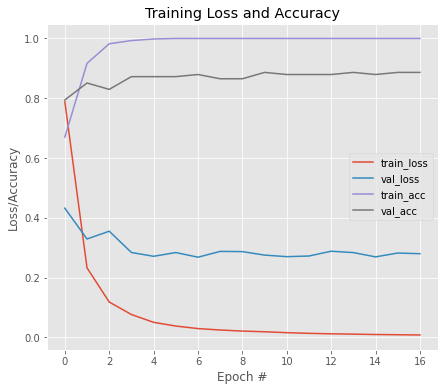


Model Performance Summary:

Best Validation accuracy:0.8865247964859009 at EPOCH:10


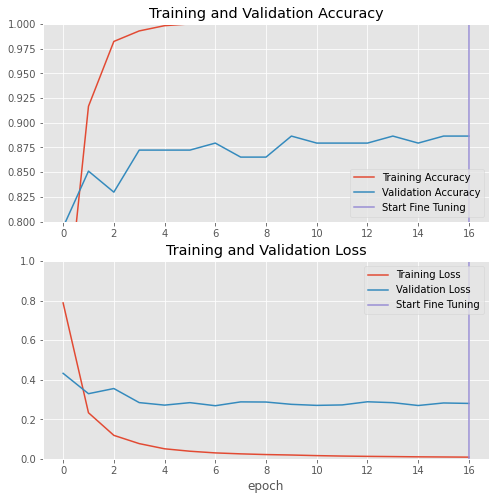

5/5 [==============================] - 2s 132ms/step
Accuracy: 0.8794326241134752
Sensitivity: 0.8793103448275862
AUC:0.8794142085583715


Model  Accuracy  Precision   Recall  \
0  EN_ACRIMA_A_False_0.2_0.0001_InceptionV3  0.879433   0.836066  0.87931   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.857143  0.879414      0.87931     0.879518  0.752963

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
219070464/219055592 [==============================] - 7s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.7647 - accuracy: 0.6028
Epoch 1: val_loss improved from inf to 0.60208, saving model to InceptionResNetV2_a.hdf5
18/18 [==============================] - 25s 780ms/step - loss: 0.7647 - accuracy: 0.6028 - val_loss: 0.6021 - val_accuracy: 0.6667
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.7908
Epoch 2: val_loss improved from 0.60208 to 0.52772, saving model to InceptionResNetV2_a.hdf5
18/18 [==============================] - 8s 475ms/step - loss: 0.4485 - accuracy: 0.7908 - val_loss: 0.5277 - val_accuracy: 0.7305
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.3587 - accuracy: 0.8564
Epoch 3: val_loss did not improve from 0.52772
18/18 [==============================] - 7s 408ms/step - loss: 0.3587 - accuracy: 0.8564 - val_loss: 0.5351 - 

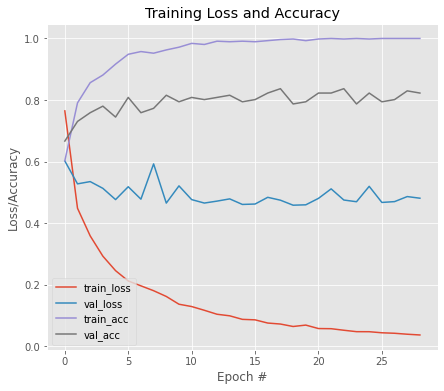


Model Performance Summary:

Best Validation accuracy:0.8368794322013855 at EPOCH:18


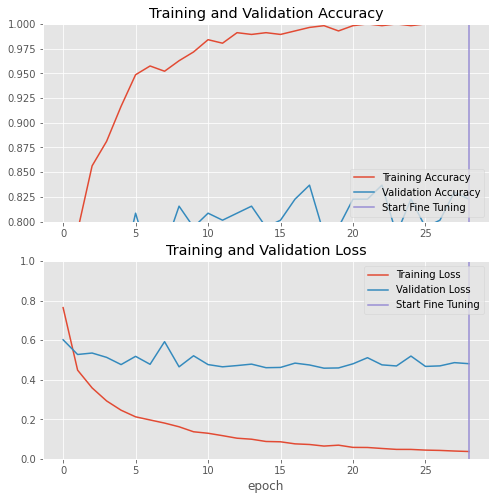

5/5 [==============================] - 4s 332ms/step
Accuracy: 0.7872340425531915
Sensitivity: 0.6379310344827587
AUC:0.7647486497714998


Model  Accuracy  Precision  \
0  EN_ACRIMA_A_False_0.2_0.0001_InceptionResNetV2  0.787234   0.804348   

     Recall        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.637931  0.711538  0.764749     0.637931     0.891566  0.546527

Height:299 Width:299
A_False_Split_0.2_lr_0.0001
83697664/83683744 [==============================] - 1s 0us/step
Epoch 1/30
18/18 [==============================] - ETA: 0s - loss: 0.6273 - accuracy: 0.6879
Epoch 1: val_loss improved from inf to 0.47040, saving model to xception_a.hdf5
18/18 [==============================] - 12s 468ms/step - loss: 0.6273 - accuracy: 0.6879 - val_loss: 0.4704 - val_accuracy: 0.7660
Epoch 2/30
18/18 [==============================] - ETA: 0s - loss: 0.2880 - accuracy: 0.8865
Epoch 2: val_loss improved from 0.47040 to 0.39618, saving model to xception_a.hdf5
18/18 [==============================] - 6s 344ms/step - loss: 0.2880 - accuracy: 0.8865 - val_loss: 0.3962 - val_accuracy: 0.8227
Epoch 3/30
18/18 [==============================] - ETA: 0s - loss: 0.2074 - accuracy: 0.9273
Epoch 3: val_loss improved from 0.39618 to 0.35939, saving model to xception_a.hdf5
18/18 [==============================] - 6s 344ms/step - loss: 0.2074 - accuracy: 0.9273 - va

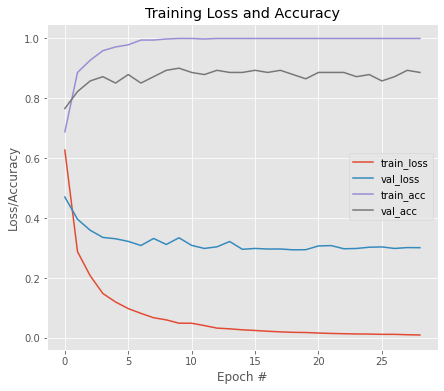


Model Performance Summary:

Best Validation accuracy:0.9007092118263245 at EPOCH:10


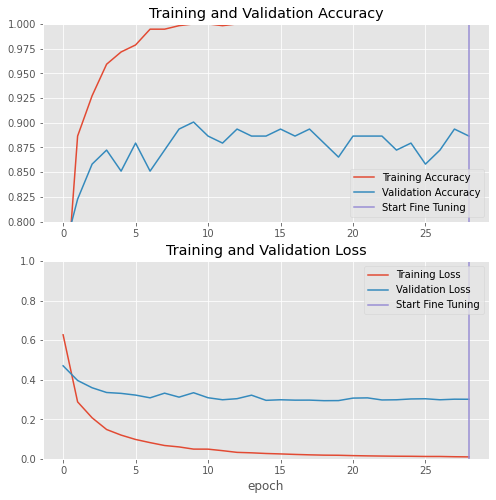

5/5 [==============================] - 2s 263ms/step
Accuracy: 0.8794326241134752
Sensitivity: 0.8793103448275862
AUC:0.8794142085583715


Model  Accuracy  Precision   Recall  \
0  EN_ACRIMA_A_False_0.2_0.0001_xception  0.879433   0.836066  0.87931   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.857143  0.879414      0.87931     0.879518  0.752963

In [ ]:
MODEL_LIST = ['vgg16','vgg19','DenseNet121','MobileNet','InceptionV3','InceptionResNetV2','xception']
split_ratio = [0.2]
data_aug = [False]
learning_rate = [0.0001]
set_seed()
for model in MODEL_LIST:
  (trainx,trainy),(testx,testy) = get_acrima_dataset(width = 299,height = 299,test_train_ratio = split_ratio[-1])
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{split_ratio[-1]}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL(model)
      name = f"EN_ACRIMA_A_{aug}_{split_ratio[-1]}_{lr}_{model}"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)

Model  Accuracy  Precision  \
9               EN_ACRIMA_A_False_0.2_0.0001_vgg16  0.936170   0.901639   
10              EN_ACRIMA_A_False_0.2_0.0001_vgg19  0.879433   0.847458   
11        EN_ACRIMA_A_False_0.2_0.0001_DenseNet121  0.893617   0.841270   
12          EN_ACRIMA_A_False_0.2_0.0001_MobileNet  0.907801   0.909091   
13        EN_ACRIMA_A_False_0.2_0.0001_InceptionV3  0.879433   0.836066   
14  EN_ACRIMA_A_False_0.2_0.0001_InceptionResNetV2  0.787234   0.804348   
15           EN_ACRIMA_A_False_0.2_0.0001_xception  0.879433   0.836066   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
9   0.948276  0.924370  0.937993     0.948276     0.927711  0.869216  
10  0.862069  0.854701  0.876818     0.862069     0.891566  0.751683  
11  0.913793  0.876033  0.896656     0.913793     0.879518  0.783144  
12  0.862069  0.884956  0.900914     0.862069     0.939759  0.808123  
13  0.879310  0.857143  0.879414     0.879310     0.879518  0.752963  
14  0.637931  0.711538  0.764749     0.637931     0.891566  0.546527  
15  0.879310  0.857143  0.879414     0.879310     0.879518  0.752963

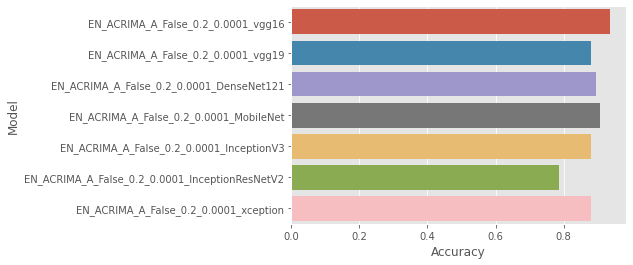

\begin{tabular}{lrrrrrrrr}
\toprule
                                         Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            EN\_ACRIMA\_A\_False\_0.2\_0.0001\_vgg16 &  0.936170 &   0.901639 & 0.948276 & 0.924370 & 0.937993 &     0.948276 &     0.927711 & 0.869216 \\
            EN\_ACRIMA\_A\_False\_0.2\_0.0001\_vgg19 &  0.879433 &   0.847458 & 0.862069 & 0.854701 & 0.876818 &     0.862069 &     0.891566 & 0.751683 \\
      EN\_ACRIMA\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.893617 &   0.841270 & 0.913793 & 0.876033 & 0.896656 &     0.913793 &     0.879518 & 0.783144 \\
        EN\_ACRIMA\_A\_False\_0.2\_0.0001\_MobileNet &  0.907801 &   0.909091 & 0.862069 & 0.884956 & 0.900914 &     0.862069 &     0.939759 & 0.808123 \\
      EN\_ACRIMA\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.879433 &   0.836066 & 0.879310 & 0.857143 & 0.879414 &     0.879310 &     0.879518 & 0.752963 \\
EN\_ACRIMA\_A\_False\_0.2\_0.00

In [ ]:
plot_performance('EN_ACRIMA_A_False_0.2_0.0001')

RIM-ONE DL

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6622 - accuracy: 0.6431
Epoch 1: val_loss improved from inf to 0.61581, saving model to vgg16_a.hdf5
11/11 [==============================] - 7s 592ms/step - loss: 0.6622 - accuracy: 0.6431 - val_loss: 0.6158 - val_accuracy: 0.6644
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6037 - accuracy: 0.6490
Epoch 2: val_loss improved from 0.61581 to 0.57645, saving model to vgg16_a.hdf5
11/11 [==============================] - 2s 230ms/step - loss: 0.6037 - accuracy: 0.6490 - val_loss: 0.5765 - val_accuracy: 0.6438
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.5716 - accuracy: 0.6726
Epoch 3: val_loss improved from 0.57645 to 0.56035, saving model to vgg16_a.hdf5
11/11 [==============================] - 2s 229ms/step - loss: 0.5716 - accuracy: 0.6726 - val_loss: 0.5604 - val_accuracy: 0.7192
Epoch 4/30
11/11 [==============================] - ETA: 0

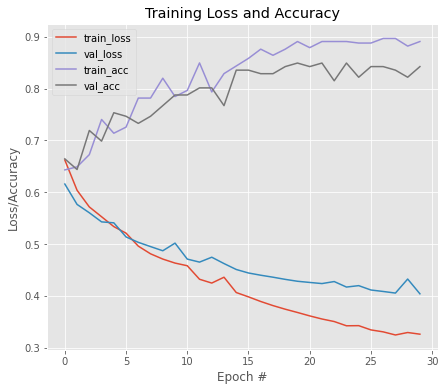


Model Performance Summary:

Best Validation accuracy:0.8493150472640991 at EPOCH:20


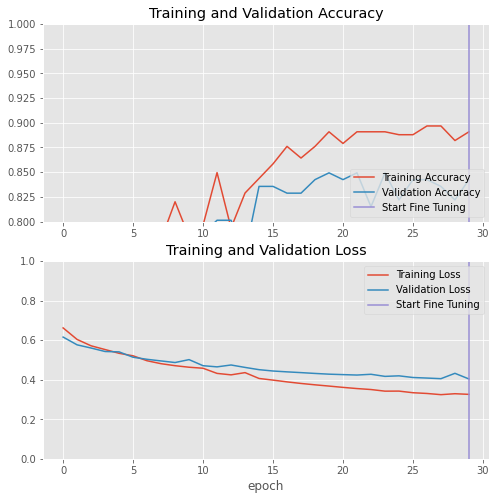

5/5 [==============================] - 1s 144ms/step
Accuracy: 0.8424657534246576
Sensitivity: 0.9468085106382979
AUC:0.8003273322422259


Model  Accuracy  Precision    Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_vgg16  0.842466   0.831776  0.946809   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.885572  0.800327     0.946809     0.653846  0.636186

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6968 - accuracy: 0.6224
Epoch 1: val_loss improved from inf to 0.66614, saving model to vgg19_a.hdf5
11/11 [==============================] - 4s 305ms/step - loss: 0.6968 - accuracy: 0.6224 - val_loss: 0.6661 - val_accuracy: 0.6301
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6351 - accuracy: 0.6372
Epoch 2: val_loss improved from 0.66614 to 0.62548, saving model to vgg19_a.hdf5
11/11 [==============================] - 3s 282ms/step - loss: 0.6351 - accuracy: 0.6372 - val_loss: 0.6255 - val_accuracy: 0.6438
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.6019 - accuracy: 0.6696
Epoch 3: val_loss improved from 0.62548 to 0.59460, saving model to vgg19_a.hdf5
11/11 [==============================] - 3s 281ms/step - loss: 0.6019 - accuracy: 0.6696 - val_loss: 0.5946 - val_accuracy: 0.6849
Epoch 4/30
11/11 [==============================] - ETA: 0

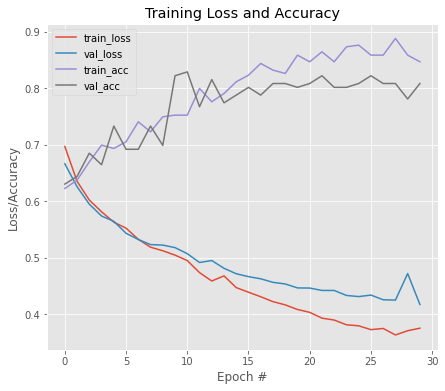


Model Performance Summary:

Best Validation accuracy:0.8287671208381653 at EPOCH:11


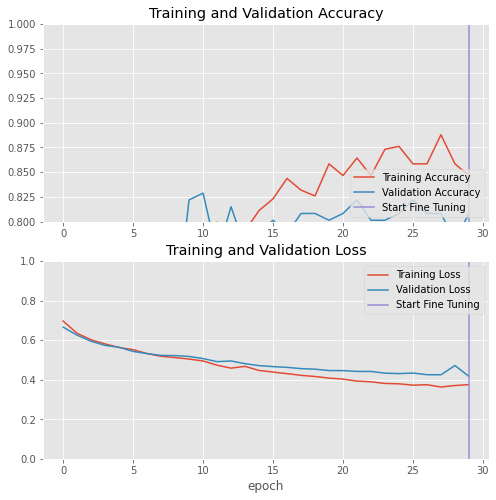

5/5 [==============================] - 1s 187ms/step
Accuracy: 0.8082191780821918
Sensitivity: 0.9042553191489362
AUC:0.7694353518821604


Model  Accuracy  Precision    Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_vgg19  0.808219   0.817308  0.904255   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.858586  0.769435     0.904255     0.634615  0.563061

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 1.4012 - accuracy: 0.5752
Epoch 1: val_loss improved from inf to 0.75769, saving model to DenseNet121_a.hdf5
11/11 [==============================] - 13s 629ms/step - loss: 1.4012 - accuracy: 0.5752 - val_loss: 0.7577 - val_accuracy: 0.5616
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.6938 - accuracy: 0.6372
Epoch 2: val_loss improved from 0.75769 to 0.64124, saving model to DenseNet121_a.hdf5
11/11 [==============================] - 2s 201ms/step - loss: 0.6938 - accuracy: 0.6372 - val_loss: 0.6412 - val_accuracy: 0.6986
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.4399 - accuracy: 0.7965
Epoch 3: val_loss improved from 0.64124 to 0.51935, saving model to DenseNet121_a.hdf5
11/11 [==============================] - 2s 199ms/step - loss: 0.4399 - accuracy: 0.7965 - val_loss: 0.5193 - val_accuracy: 0.7329
Epoch 4/30
11/11 [=====================

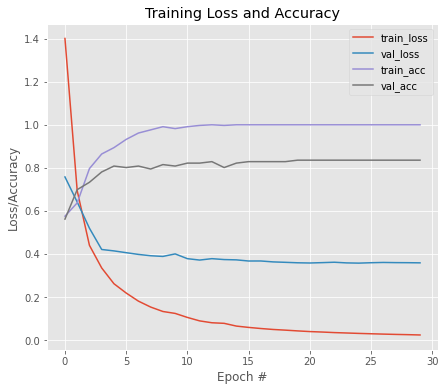


Model Performance Summary:

Best Validation accuracy:0.835616409778595 at EPOCH:20


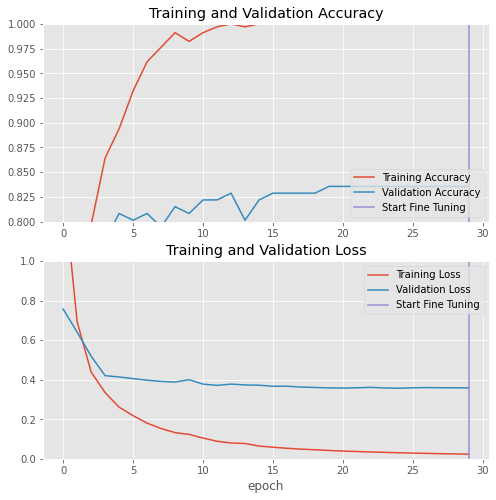

5/5 [==============================] - 2s 105ms/step
Accuracy: 0.8356164383561644
Sensitivity: 0.8723404255319149
AUC:0.820785597381342


Model  Accuracy  Precision   Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_DenseNet121  0.835616    0.87234  0.87234   

        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.87234  0.820786      0.87234     0.769231  0.641571

A_False_Split_0.2_lr_0.0001
Epoch 1/30
10/11 [==========================>...] - ETA: 0s - loss: 0.7847 - accuracy: 0.6450
Epoch 1: val_loss improved from inf to 0.40835, saving model to MobileNet_a.hdf5
11/11 [==============================] - 3s 173ms/step - loss: 0.7561 - accuracy: 0.6637 - val_loss: 0.4084 - val_accuracy: 0.8014
Epoch 2/30
10/11 [==========================>...] - ETA: 0s - loss: 0.2771 - accuracy: 0.9023
Epoch 2: val_loss improved from 0.40835 to 0.34062, saving model to MobileNet_a.hdf5
11/11 [==============================] - 1s 79ms/step - loss: 0.2657 - accuracy: 0.8997 - val_loss: 0.3406 - val_accuracy: 0.8493
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.1226 - accuracy: 0.9705
Epoch 3: val_loss did not improve from 0.34062
11/11 [==============================] - 1s 64ms/step - loss: 0.1226 - accuracy: 0.9705 - val_loss: 0.3717 - val_accuracy: 0.8630
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.0682 - accuracy:

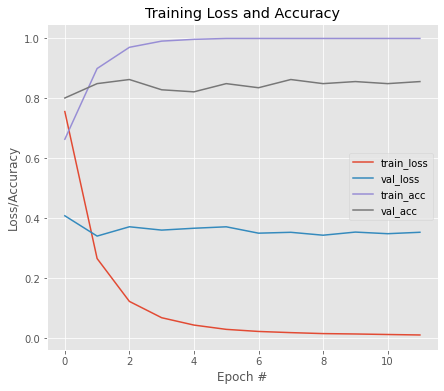


Model Performance Summary:

Best Validation accuracy:0.8630136847496033 at EPOCH:3


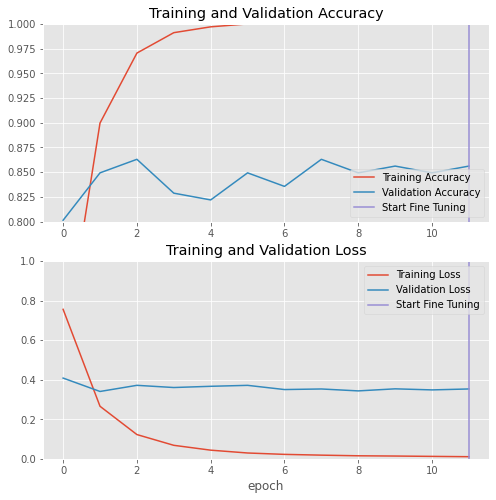

5/5 [==============================] - 1s 34ms/step
Accuracy: 0.8493150684931506
Sensitivity: 0.8723404255319149
AUC:0.8400163666121114


Model  Accuracy  Precision   Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_MobileNet  0.849315   0.891304  0.87234   

        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.88172  0.840016      0.87234     0.807692  0.674239

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7050
Epoch 1: val_loss improved from inf to 0.59598, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 11s 645ms/step - loss: 0.6214 - accuracy: 0.7050 - val_loss: 0.5960 - val_accuracy: 0.7397
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.8968
Epoch 2: val_loss improved from 0.59598 to 0.43012, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 2s 224ms/step - loss: 0.2101 - accuracy: 0.8968 - val_loss: 0.4301 - val_accuracy: 0.8356
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0914 - accuracy: 0.9794
Epoch 3: val_loss improved from 0.43012 to 0.42744, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 2s 224ms/step - loss: 0.0914 - accuracy: 0.9794 - val_loss: 0.4274 - val_accuracy: 0.8356
Epoch 4/30
11/11 [=====================

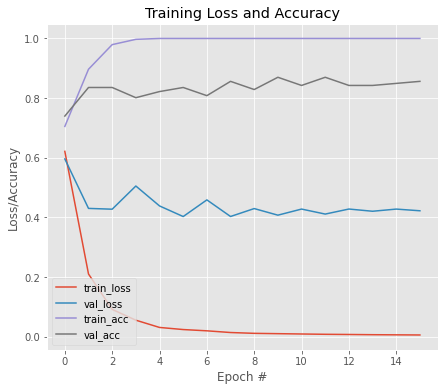


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:10


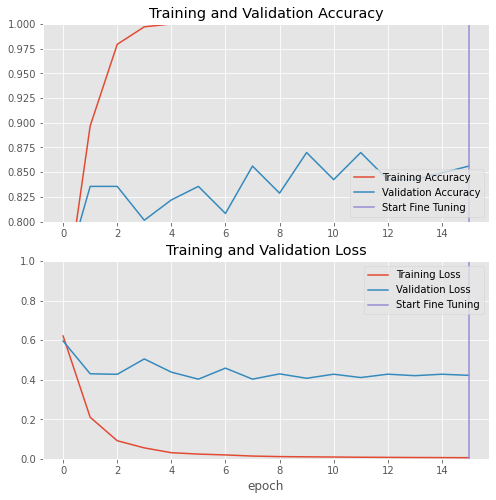

5/5 [==============================] - 2s 131ms/step
Accuracy: 0.8356164383561644
Sensitivity: 0.8723404255319149
AUC:0.820785597381342


Model  Accuracy  Precision   Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_InceptionV3  0.835616    0.87234  0.87234   

        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.87234  0.820786      0.87234     0.769231  0.641571

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6547 - accuracy: 0.6401
Epoch 1: val_loss improved from inf to 0.51745, saving model to InceptionResNetV2_a.hdf5
11/11 [==============================] - 22s 1s/step - loss: 0.6547 - accuracy: 0.6401 - val_loss: 0.5175 - val_accuracy: 0.7671
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.3586 - accuracy: 0.8702
Epoch 2: val_loss improved from 0.51745 to 0.48845, saving model to InceptionResNetV2_a.hdf5
11/11 [==============================] - 6s 583ms/step - loss: 0.3586 - accuracy: 0.8702 - val_loss: 0.4885 - val_accuracy: 0.7534
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.2578 - accuracy: 0.8938
Epoch 3: val_loss did not improve from 0.48845
11/11 [==============================] - 5s 467ms/step - loss: 0.2578 - accuracy: 0.8938 - val_loss: 0.5589 - val_accuracy: 0.7192
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.

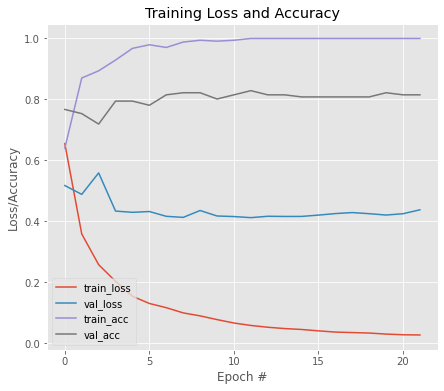


Model Performance Summary:

Best Validation accuracy:0.8287671208381653 at EPOCH:12


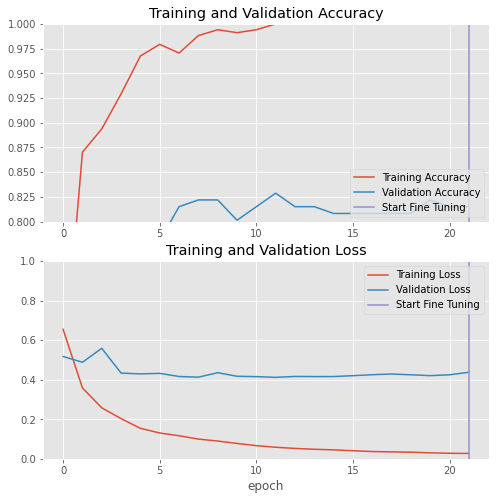

5/5 [==============================] - 4s 323ms/step
Accuracy: 0.8287671232876712
Sensitivity: 0.9042553191489362
AUC:0.7982815057283144


Model  Accuracy  Precision  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_InceptionResN...  0.828767   0.841584   

     Recall        F1       AUC  Sensitivity  Specificity    Kappa  
0  0.904255  0.871795  0.798282     0.904255     0.692308  0.61506

A_False_Split_0.2_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6882 - accuracy: 0.6932
Epoch 1: val_loss improved from inf to 0.49486, saving model to xception_a.hdf5
11/11 [==============================] - 9s 629ms/step - loss: 0.6882 - accuracy: 0.6932 - val_loss: 0.4949 - val_accuracy: 0.7740
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.3327 - accuracy: 0.8525
Epoch 2: val_loss improved from 0.49486 to 0.46081, saving model to xception_a.hdf5
11/11 [==============================] - 4s 401ms/step - loss: 0.3327 - accuracy: 0.8525 - val_loss: 0.4608 - val_accuracy: 0.8082
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.2398 - accuracy: 0.9027
Epoch 3: val_loss did not improve from 0.46081
11/11 [==============================] - 4s 366ms/step - loss: 0.2398 - accuracy: 0.9027 - val_loss: 0.5037 - val_accuracy: 0.7808
Epoch 4/30
11/11 [==============================] - ETA: 0s - loss: 0.1725 - accuracy:

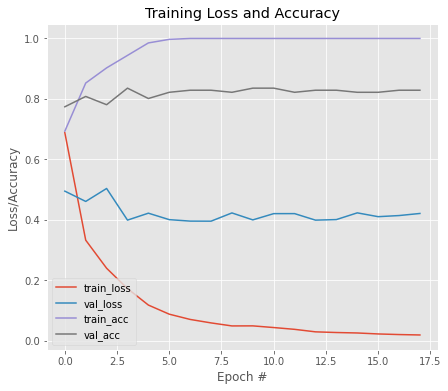


Model Performance Summary:

Best Validation accuracy:0.835616409778595 at EPOCH:4


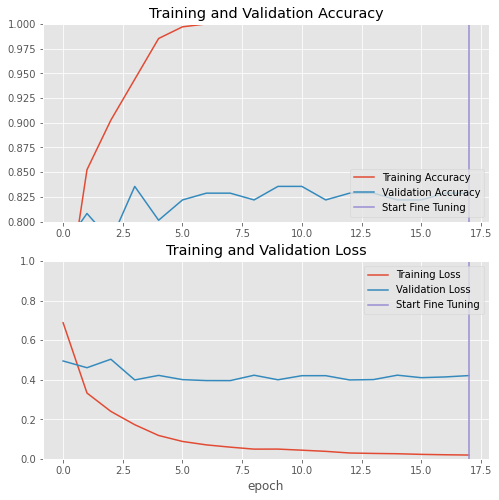

5/5 [==============================] - 2s 260ms/step
Accuracy: 0.8287671232876712
Sensitivity: 0.8936170212765957
AUC:0.8025777414075287


Model  Accuracy  Precision    Recall  \
0  EN_RIM-ONE_dl_A_False_0.2_0.0001_xception  0.828767   0.848485  0.893617   

         F1       AUC  Sensitivity  Specificity    Kappa  
0  0.870466  0.802578     0.893617     0.711538  0.61844

In [ ]:
MODEL_LIST = ['vgg16','vgg19','DenseNet121','MobileNet','InceptionV3','InceptionResNetV2','xception']
split_ratio = [0.2]
data_aug = [False]
learning_rate = [0.0001]
set_seed()
for model in MODEL_LIST:
  (trainx,trainy),(testx,testy) = get_rim_one_dl(width = 299,height = 299)
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{split_ratio[-1]}_lr_{lr}")
      model_obj = HIGH_LEVEL_MODEL(model)
      name = f"EN_RIM-ONE_dl_A_{aug}_{split_ratio[-1]}_{lr}_{model}"
      model_obj.train_phase(trainx,trainy,testx,testy,data_aug=aug,model_name = name,lr=lr)

Model  Accuracy  Precision  \
16             EN_RIM-ONE_dl_A_False_0.2_0.0001_vgg16  0.842466   0.831776   
17             EN_RIM-ONE_dl_A_False_0.2_0.0001_vgg19  0.808219   0.817308   
18       EN_RIM-ONE_dl_A_False_0.2_0.0001_DenseNet121  0.835616   0.872340   
19         EN_RIM-ONE_dl_A_False_0.2_0.0001_MobileNet  0.849315   0.891304   
20       EN_RIM-ONE_dl_A_False_0.2_0.0001_InceptionV3  0.835616   0.872340   
21  EN_RIM-ONE_dl_A_False_0.2_0.0001_InceptionResN...  0.828767   0.841584   
22          EN_RIM-ONE_dl_A_False_0.2_0.0001_xception  0.828767   0.848485   

      Recall        F1       AUC  Sensitivity  Specificity     kappa  
16  0.946809  0.885572  0.800327     0.946809     0.653846  0.636186  
17  0.904255  0.858586  0.769435     0.904255     0.634615  0.563061  
18  0.872340  0.872340  0.820786     0.872340     0.769231  0.641571  
19  0.872340  0.881720  0.840016     0.872340     0.807692  0.674239  
20  0.872340  0.872340  0.820786     0.872340     0.769231  0.641571  
21  0.904255  0.871795  0.798282     0.904255     0.692308  0.615060  
22  0.893617  0.870466  0.802578     0.893617     0.711538  0.618440

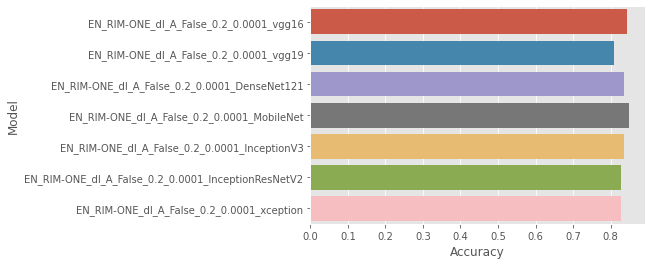

\begin{tabular}{lrrrrrrrr}
\toprule
                                             Model &  Accuracy &  Precision &   Recall &       F1 &      AUC &  Sensitivity &  Specificity &    kappa \\
\midrule
            EN\_RIM-ONE\_dl\_A\_False\_0.2\_0.0001\_vgg16 &  0.842466 &   0.831776 & 0.946809 & 0.885572 & 0.800327 &     0.946809 &     0.653846 & 0.636186 \\
            EN\_RIM-ONE\_dl\_A\_False\_0.2\_0.0001\_vgg19 &  0.808219 &   0.817308 & 0.904255 & 0.858586 & 0.769435 &     0.904255 &     0.634615 & 0.563061 \\
      EN\_RIM-ONE\_dl\_A\_False\_0.2\_0.0001\_DenseNet121 &  0.835616 &   0.872340 & 0.872340 & 0.872340 & 0.820786 &     0.872340 &     0.769231 & 0.641571 \\
        EN\_RIM-ONE\_dl\_A\_False\_0.2\_0.0001\_MobileNet &  0.849315 &   0.891304 & 0.872340 & 0.881720 & 0.840016 &     0.872340 &     0.807692 & 0.674239 \\
      EN\_RIM-ONE\_dl\_A\_False\_0.2\_0.0001\_InceptionV3 &  0.835616 &   0.872340 & 0.872340 & 0.872340 & 0.820786 &     0.872340 &     0.769231 & 0.641571 \\
EN

In [ ]:
plot_performance('EN_RIM-ONE_dl_A_False_0.2_0.0001')

RIMONE DL DATASET

Mode Generalisation

Height:299 Width:299 test_train_ratio:0.1
Height:299 Width:299
A_False_Split_0.1_lr_0.0001
Epoch 1/30
13/13 [==============================] - ETA: 0s - loss: 1.1340 - accuracy: 0.6064
Epoch 1: val_loss improved from inf to 0.67874, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 10s 280ms/step - loss: 1.1340 - accuracy: 0.6064 - val_loss: 0.6787 - val_accuracy: 0.7174
Epoch 2/30
13/13 [==============================] - ETA: 0s - loss: 0.4123 - accuracy: 0.8191
Epoch 2: val_loss did not improve from 0.67874
13/13 [==============================] - 1s 94ms/step - loss: 0.4123 - accuracy: 0.8191 - val_loss: 0.7337 - val_accuracy: 0.7174
Epoch 3/30
13/13 [==============================] - ETA: 0s - loss: 0.2011 - accuracy: 0.9095
Epoch 3: val_loss improved from 0.67874 to 0.56313, saving model to InceptionV3_a.hdf5
13/13 [==============================] - 2s 146ms/step - loss: 0.2011 - accuracy: 0.9095 - val_loss: 0.5631 - val_accuracy: 0.7826
Epoch 4/30
13/13 

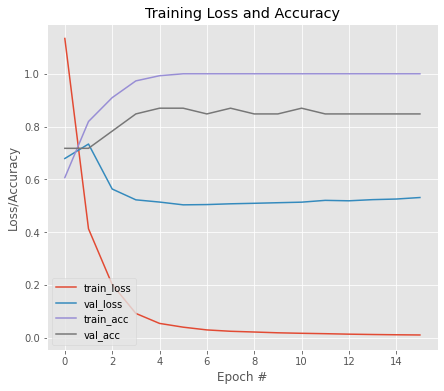


Model Performance Summary:

Best Validation accuracy:0.8695651888847351 at EPOCH:5


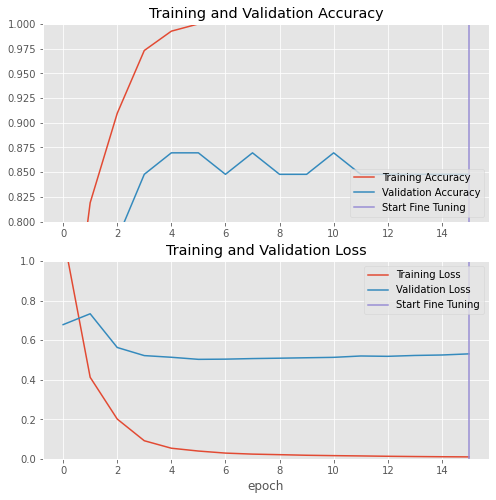

2/2 [==============================] - 2s 68ms/step
Accuracy: 0.8695652173913043
Sensitivity: 0.8636363636363636
AUC:0.8693181818181819


Model  Accuracy  Precision    Recall  \
0  RIM-ONE_v2_A_False_0.1_0.0001_InceptionV3  0.869565   0.863636  0.863636   

         F1       AUC  Sensitivity  Specificity     Kappa  
0  0.863636  0.869318     0.863636        0.875  0.738636

RIM-ONEv2 - ACRIMA
3/3 [==============================] - 2s 69ms/step
Accuracy: 0.4507042253521127
Sensitivity: 0.5161290322580645
RIM-ONEv2 - RIM-ONE dl
5/5 [==============================] - 2s 68ms/step
Accuracy: 0.1506849315068493
Sensitivity: 0.2127659574468085
A_False_Split_0.1_lr_0.0001
Epoch 1/30
11/11 [==============================] - ETA: 0s - loss: 0.6214 - accuracy: 0.7050
Epoch 1: val_loss improved from inf to 0.59598, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 10s 385ms/step - loss: 0.6214 - accuracy: 0.7050 - val_loss: 0.5960 - val_accuracy: 0.7397
Epoch 2/30
11/11 [==============================] - ETA: 0s - loss: 0.2101 - accuracy: 0.8968
Epoch 2: val_loss improved from 0.59598 to 0.43012, saving model to InceptionV3_a.hdf5
11/11 [==============================] - 2s 185ms/step - loss: 0.2101 - accuracy: 0.8968 - val_loss: 0.4301 - val_accuracy: 0.8356
Epoch 3/30
11/11 [==============================] - ETA: 0s - loss: 0.0914 - accura

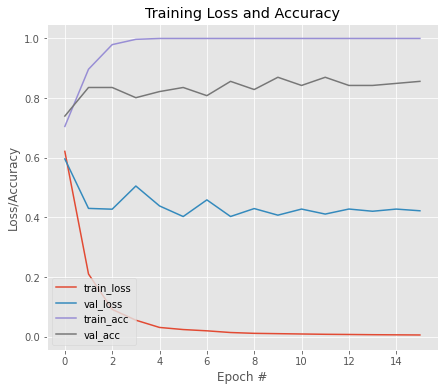


Model Performance Summary:

Best Validation accuracy:0.8698630332946777 at EPOCH:10


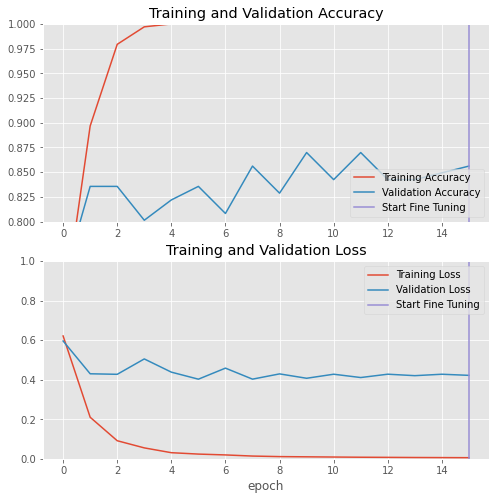

5/5 [==============================] - 2s 68ms/step
Accuracy: 0.8356164383561644
Sensitivity: 0.8723404255319149
AUC:0.820785597381342


Model  Accuracy  Precision   Recall  \
0  RIM-ONE_dl_A_False_0.1_0.0001_InceptionV3  0.835616    0.87234  0.87234   

        F1       AUC  Sensitivity  Specificity     Kappa  
0  0.87234  0.820786      0.87234     0.769231  0.641571

RIM-ONE dl - ACRIMA
3/3 [==============================] - 2s 70ms/step
Accuracy: 0.5211267605633803
Sensitivity: 0.8387096774193549
RIM-ONE dl - RIM-ONE v2
2/2 [==============================] - 2s 66ms/step
Accuracy: 0.1956521739130435
Sensitivity: 0.4090909090909091


In [ ]:
split_ratio = [0.1]
data_aug = [False]
learning_rate = [0.0001]
set_seed()
for ratio in split_ratio:
  (trainx1,trainy1),(testx1,testy1) = get_rim_one_db_r2(width = 299,height = 299,test_train_ratio = ratio)
  (trainx2,trainy2),(testx2,testy2) = get_acrima_dataset(width = 299,height = 299,test_train_ratio = ratio)
  (trainx3,trainy3),(testx3,testy3) = get_rim_one_dl(width = 299,height = 299)
  for aug in data_aug:
    for lr in learning_rate:
      set_seed()
      print(f"A_{aug}_Split_{ratio}_lr_{lr}")
      trained_model_obj = HIGH_LEVEL_MODEL("InceptionV3")
      name = f"RIM-ONE_v2_A_{aug}_{ratio}_{lr}_InceptionV3"
      trained_model_obj.train_phase(trainx1,trainy1,testx1,testy1,data_aug=aug,model_name = name,lr=lr)
      print(f"RIM-ONEv2 - ACRIMA")
      trained_model_obj.get_scores(testx2,testy2)
      print(f"RIM-ONEv2 - RIM-ONE dl")
      trained_model_obj.get_scores(testx3,testy3)

      print(f"A_{aug}_Split_{ratio}_lr_{lr}")
      trained_model_obj = HIGH_LEVEL_MODEL("InceptionV3")
      name = f"RIM-ONE_dl_A_{aug}_{ratio}_{lr}_InceptionV3"
      trained_model_obj.train_phase(trainx3,trainy3,testx3,testy3,data_aug=aug,model_name = name,lr=lr)
      print(f"RIM-ONE dl - ACRIMA")
      trained_model_obj.get_scores(testx2,testy2)
      print(f"RIM-ONE dl - RIM-ONE v2")
      trained_model_obj.get_scores(testx1,testy1)

      
      


In [ ]:
gc.collect()

88